## 特徴量のカンペはこちら ⇒ https://docs.google.com/spreadsheets/d/1T59ieP110cFg8MfOtIbW2M60iWuSwnIf/edit?usp=share_link&ouid=111727008586725963366&rtpof=true&sd=true

## Kaggle用データのインポート

In [1]:
from google.colab import drive
drive.mount('/content/drive')

COMPETITION = "house-prices-advanced-regression-techniques"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle"

import os

if not(os.path.exists(WORK_DIR)):
  os.mkdir(WORK_DIR)
os.chdir(WORK_DIR)

from google.colab import files
files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"droeloe","key":"c330037c8e955090c87e6872ec333b32"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c {COMPETITION} # copy from competition page!
!unzip {COMPETITION}
!rm {COMPETITION}.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 19.6MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ｎ
error:  invalid response [ｎ]
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## ライブラリのインポート

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE) # seabornのデフォルトの色を変更する
BACKCOLOR = '#f6f5f5'

from scipy.special import boxcox1p
from IPython.core.display import HTML
from scipy.stats import norm, skew #for some statistics
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor 

## 前準備

### User modules

In [4]:
# 並び替え検定用の関数
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [5]:
# permutation test
def permutation_test(data, var, target):

  vA = data[var].dropna().unique()[0]
  vB = data[var].dropna().unique()[1]
  mean_a = data[data[var] == vA][target].mean()
  mean_b = data[data[var] == vB][target].mean()
  print(f"{target} mean value with {var}={vA}: {mean_a}")
  print(f"{target} mean value with {var}={vB}: {mean_b}")
  print(f"{target} observed difference between ({var}={vA}) and ({var}={vB}): {mean_b - mean_a}")
  nA = data[data[var] == vA].shape[0]
  nB = data[data[var] == vB].shape[0]

  random.seed(1)
  perm_diffs = pd.Series([perm_fun(data[target], nA, nB) for _ in range(1000)])
  perm_diffs = perm_diffs.dropna()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.hist(perm_diffs, bins=11, rwidth=0.9)
  ax.axvline(x = mean_b - mean_a, color='black', lw=2)
  ax.text(mean_b - mean_a, 10, 'Observed\ndifference', bbox={'facecolor':'white'})
  ax.set_xlabel(f'{var} differences')
  ax.set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

  perm_diffs = np.array(perm_diffs)
  print('p-value: ', (np.mean(perm_diffs > mean_b - mean_a)))

In [6]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [7]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [8]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

In [9]:
# ANOVA using permutation test
# Image size が ～～～ のエラーが出た場合は logx = True に設定する
def anova_perm(data, var, target, logx=False):

  # Creating crosstab
  crosstb = pd.crosstab(data[var], data[target])
  
  # Creating barplot
  # pl = crosstb.plot(kind="bar", stacked=True, rot=0)

  for col in data[var].unique():
      try:
          true_ratio = len(data[(data[var]==col)&(data[target]==True)]) / len(data[data[var]==col])
      except:
          break
      print(col, true_ratio)

  observed_variance = data.groupby(var).mean().var()[target] # グループごとの平均値を求め、その平均値の分散を計算している
  print('Observed means:', data.groupby(var).mean()[target].values.ravel()) # ravel: 横方向の1次元のベクトルを返す
  print('Variance:', observed_variance)
  # Permutation test example with stickiness
  def perm_test(data):
      data = data.copy()
      data[target] = np.random.permutation(data[target].values)
      return data.groupby(var).mean().var()[target]
    
  random.seed(1)
  perm_variance = [perm_test(data) for _ in range(3000)]
  print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

  if logx == True:
    # 横長のグラフになってしまうので自然対数を取った（通常は下記2行は不要）
    observed_variance_log = np.log(observed_variance)
    perm_variance_log = np.log(perm_variance)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance_log, bins=11, rwidth=0.9)

    # 横長のグラフになってしまうので自然対数を取った（通常はxにobserved_varianceを指定）
    ax.axvline(x = observed_variance_log, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance, bins=11, rwidth=0.9)

    ax.axvline(x = observed_variance, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

## データのダウンロード

In [10]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

## Check data

In [11]:
all_data.head(10).style.background_gradient()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000000,Unf,0.000000,150.000000,856.000000,GasA,Ex,Y,SBrkr,856,854,0,1710,1.000000,0.000000,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2.000000,548.000000,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000000,Unf,0.000000,284.000000,1262.000000,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.000000,1.000000,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2.000000,460.000000,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000000,Unf,0.000000,434.000000,920.000000,GasA,Ex,Y,SBrkr,920,866,0,1786,1.000000,0.000000,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2.000000,608.000000,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500.000000
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.000000,Unf,0.000000,540.000000,756.000000,GasA,Gd,Y,SBrkr,961,756,0,1717,1.000000,0.000000,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3.000000,642.000000,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000.000000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.000000,Unf,0.000000,490.000000,1145.000000,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.000000,0.000000,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3.000000,836.000000,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000.000000
5,6,50,RL,85.000000,14115,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,Wood,Gd,TA,No,GLQ,732.000000,Unf,0.000000,64.000000,796.000000,GasA,Ex,Y,SBrkr,796,566,0,1362,1.000000,0.000000,1,1,1,1,TA,5,Typ,0,nan,Attchd,1993.000000,Unf,2.000000,480.000000,TA,TA,Y,40,30,0,320,0,0,nan,MnPrv,Shed,700,10,2009,WD,Normal,143000.000000
6,7,20,RL,75.000000,10084,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.000000,Unf,0.000000,317.000000,1686.000000,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.000000,0.000000,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000000,RFn,2.000000,636.000000,TA,TA,Y,255,57,0,0,0,0,nan,nan,nan,0,8,2007,WD,Normal,307000.000000
7,8,60,RL,nan,10382,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.000000,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.000000,BLQ,32.000000,216.000000,1107.000000,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.000000,0.000000,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.000000,

In [12]:
print(f'\033[32mtrain size : {train.shape[0]} x {train.shape[1]}')
print(f'\033[32mtest size : {test.shape[0]} x {test.shape[1]}')
print(f'\033[32mtotal size : {all_data.shape[0]} x {all_data.shape[1]}')

train size : 1460 x 81
test size : 1459 x 80
total size : 2919 x 81


## カラムの説明
- （各カラムの情報を記載する。不要かも？）

In [13]:
all_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [14]:
all_data.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 81, dtype: int64

In [15]:
!cat data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## カテゴリ変数の定義

### 量的変数、カテゴリ変数の定義
自動で数的変数、カテゴリ変数、名義尺度 等を判別する

In [16]:
all_data["Neighborhood"].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64

In [17]:
# categorical_cols = []
# numerical_cols = []
# boolean_cols = []
# nominal_cols = []
# for col in train.columns:
#   if train[col].dtype in ['float', "int"]:
#     numerical_cols.append(col)
#   else:
#     if len(train[col].unique()) < 3:
#       boolean_cols.append(col)
#     elif len(train[col].unique()) < 20:
#       categorical_cols.append(col)
#     else:
#       nominal_cols.append(col)

# num_to_cat = ["MSSubClass"]
# num_to_nominal = ["Id"]
# for col in num_to_cat:
#   categorical_cols.append(col)
#   numerical_cols.remove(col)
# for col in num_to_nominal:
#   nominal_cols.append(col)
#   numerical_cols.remove(col)
# print('categorical_cols = ', categorical_cols)
# print('numerical_cols = ', numerical_cols)
# print('boolean_cols = ', boolean_cols)
# print('nominal_cols = ', nominal_cols)

In [18]:
categorical_cols = []
numerical_cols = []
for i in all_data.columns.tolist():
    if all_data[i].dtype=='object':
        categorical_cols.append(i)
    else:
        numerical_cols.append(i)
print('Number of categorical features:', str(len(categorical_cols)))
print('Number of numerical features:', str(len(numerical_cols)))

Number of categorical features: 43
Number of numerical features: 38


In [19]:
multi_table([pd.DataFrame(all_data[i].value_counts()) for i in all_data.columns if i in categorical_cols])

,MSZoning
RL,2265
RM,460
FV,139
RH,26
C (all),25
,Street
Pave,2907
Grvl,12
,Alley
Grvl,120


# データの概形確認

## 欠損値の確認

<Axes: >

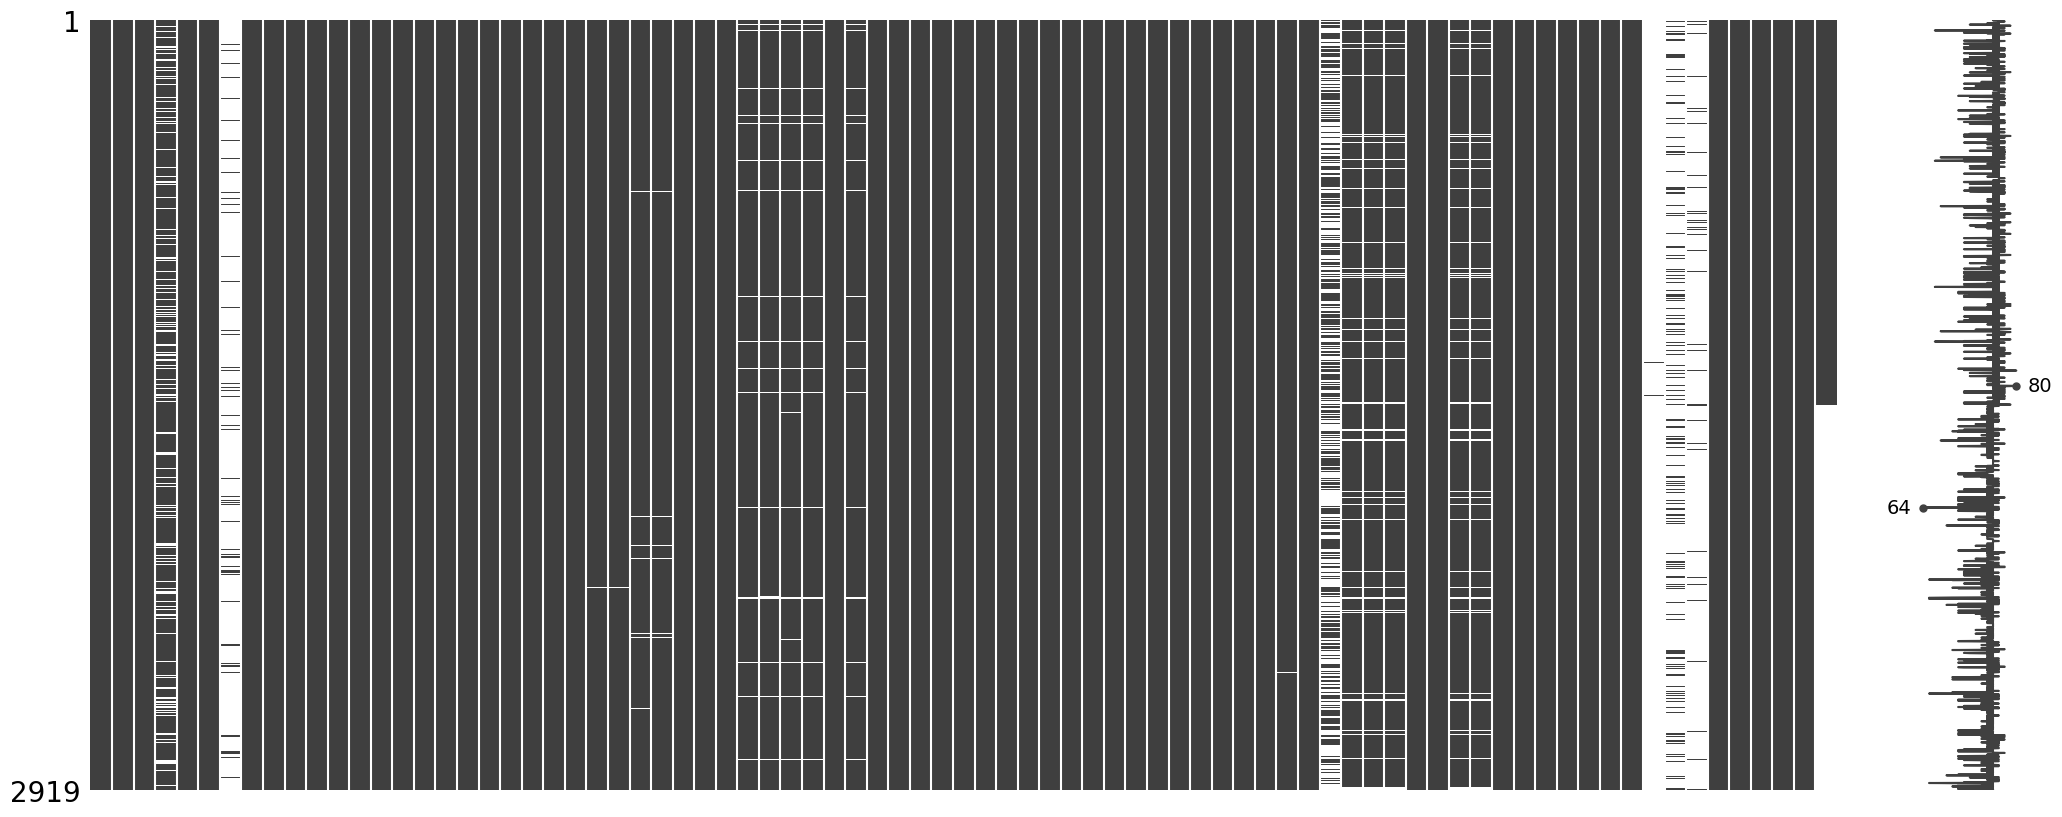

In [20]:
msno.matrix(all_data)

<Axes: >

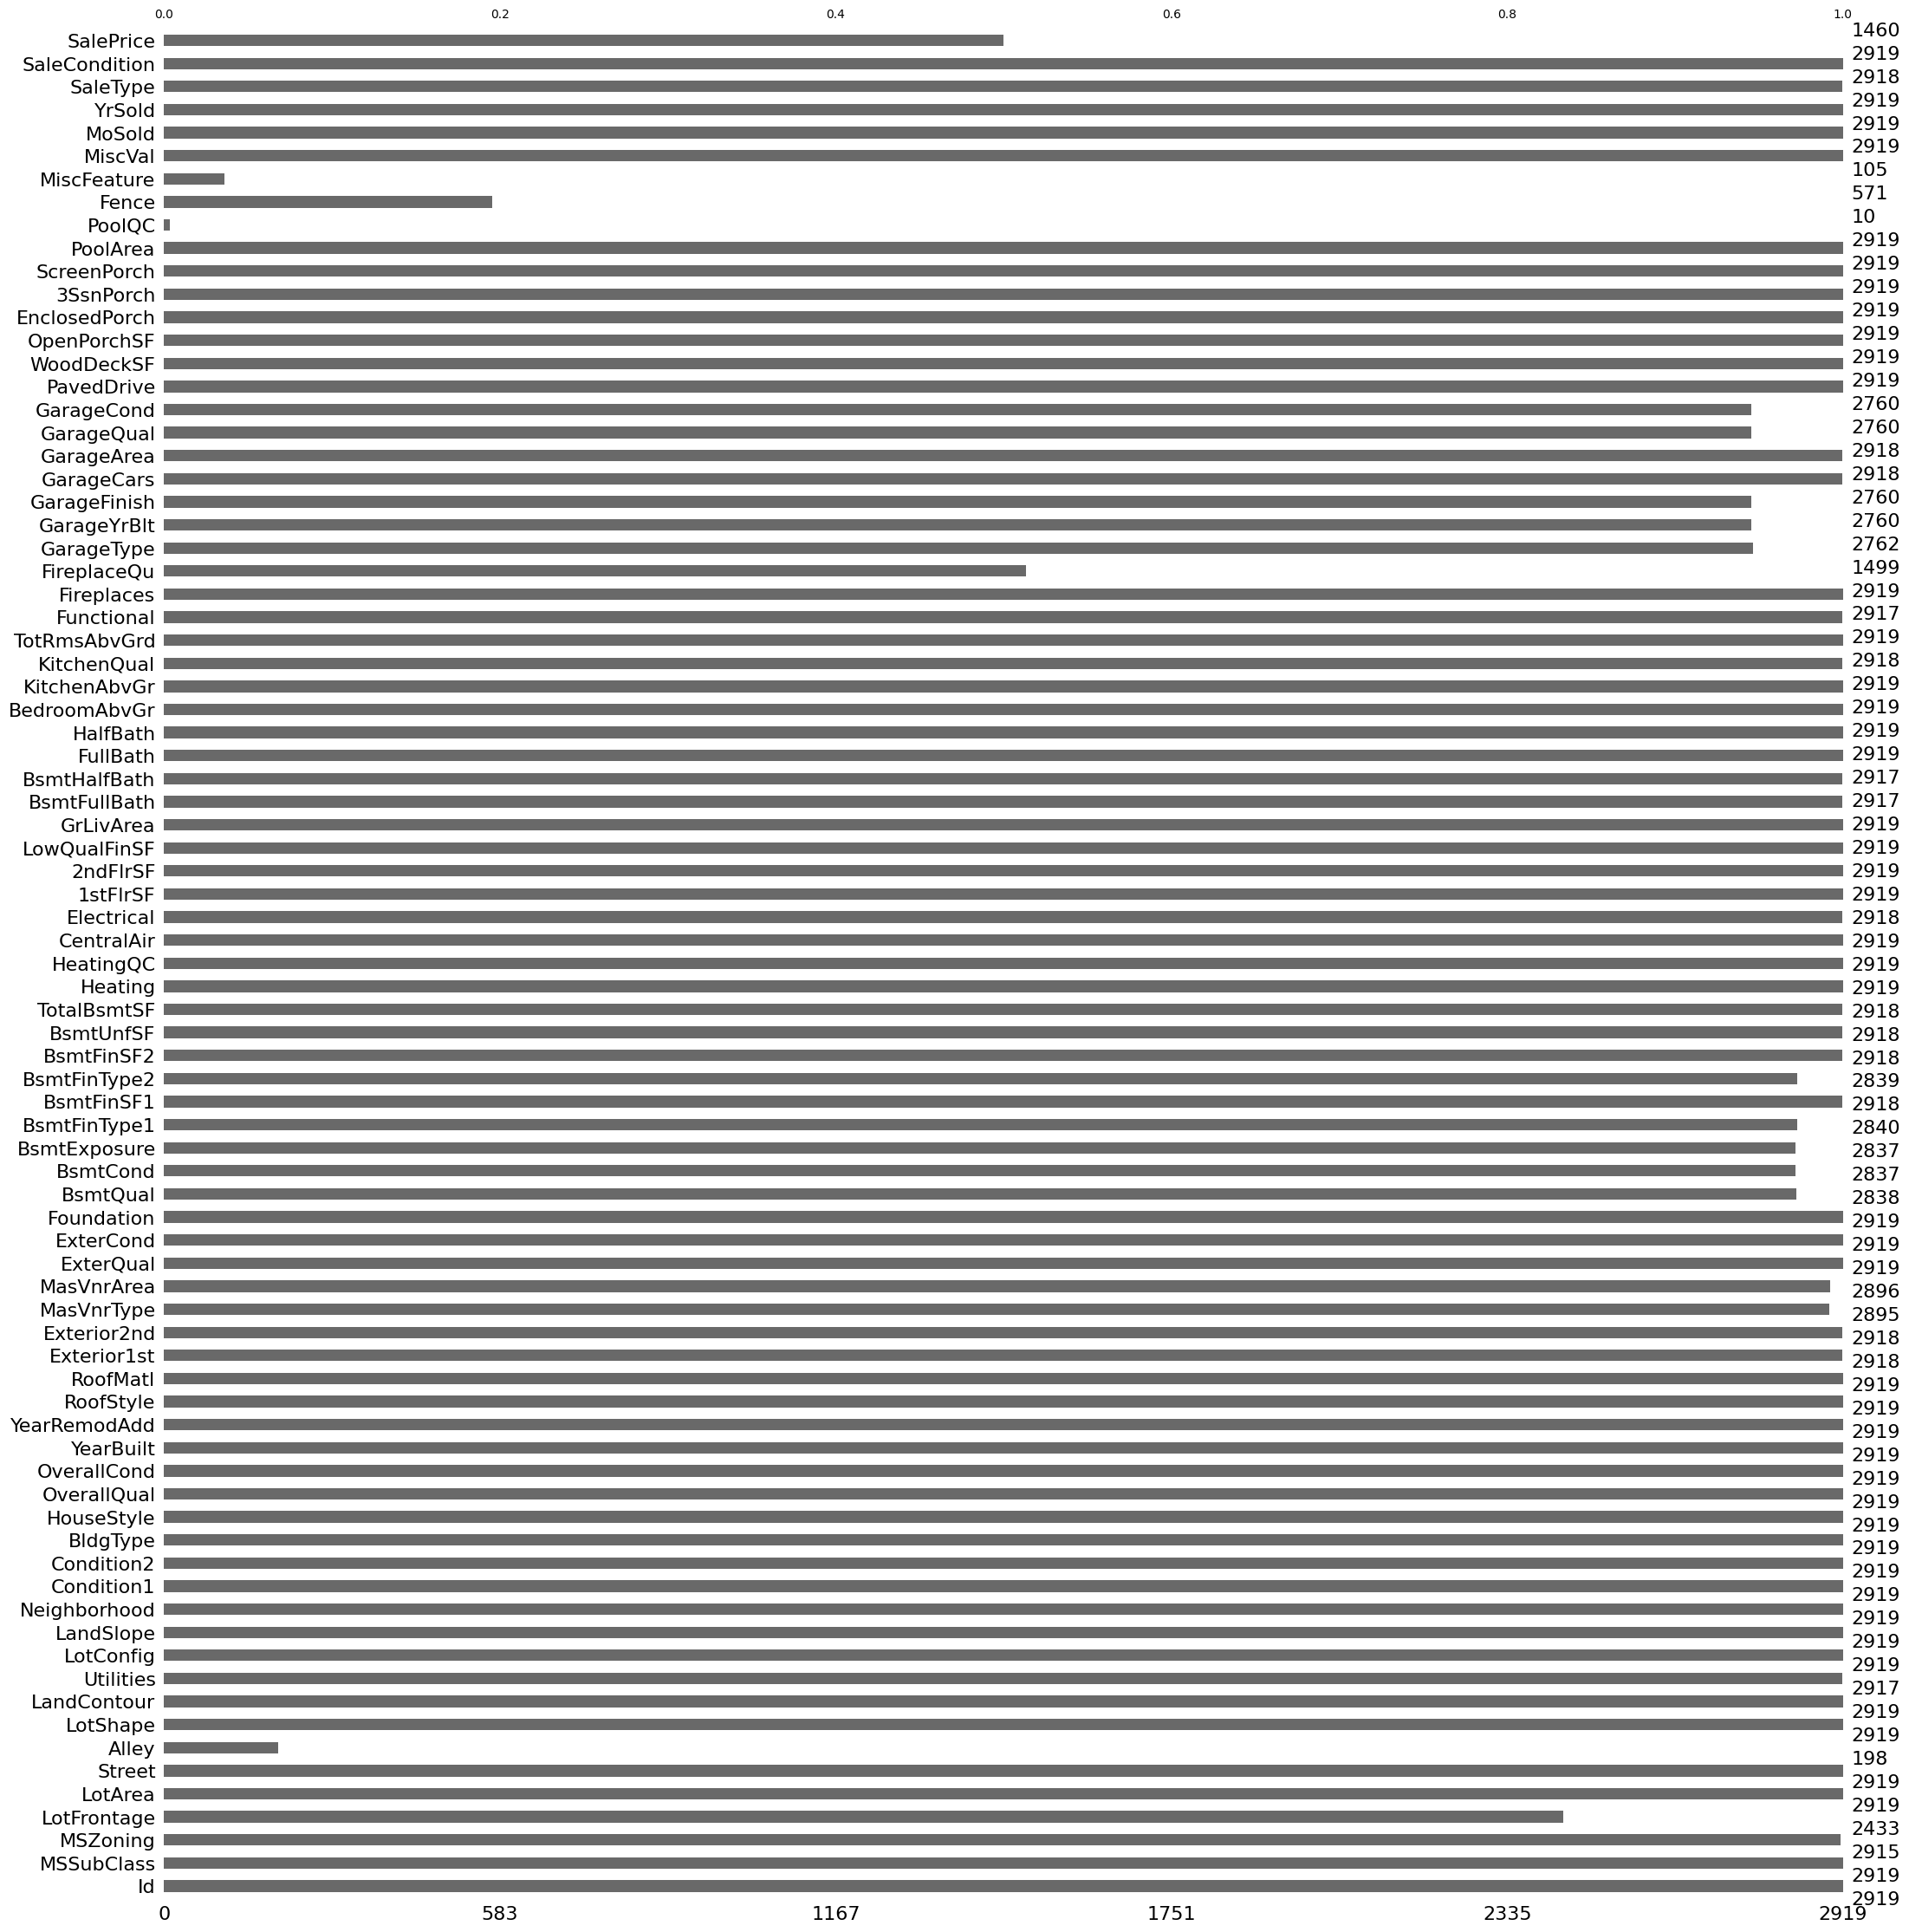

In [21]:
msno.bar(all_data)

## 分布の確認

#### Target の確認(Dependent, Nominal)

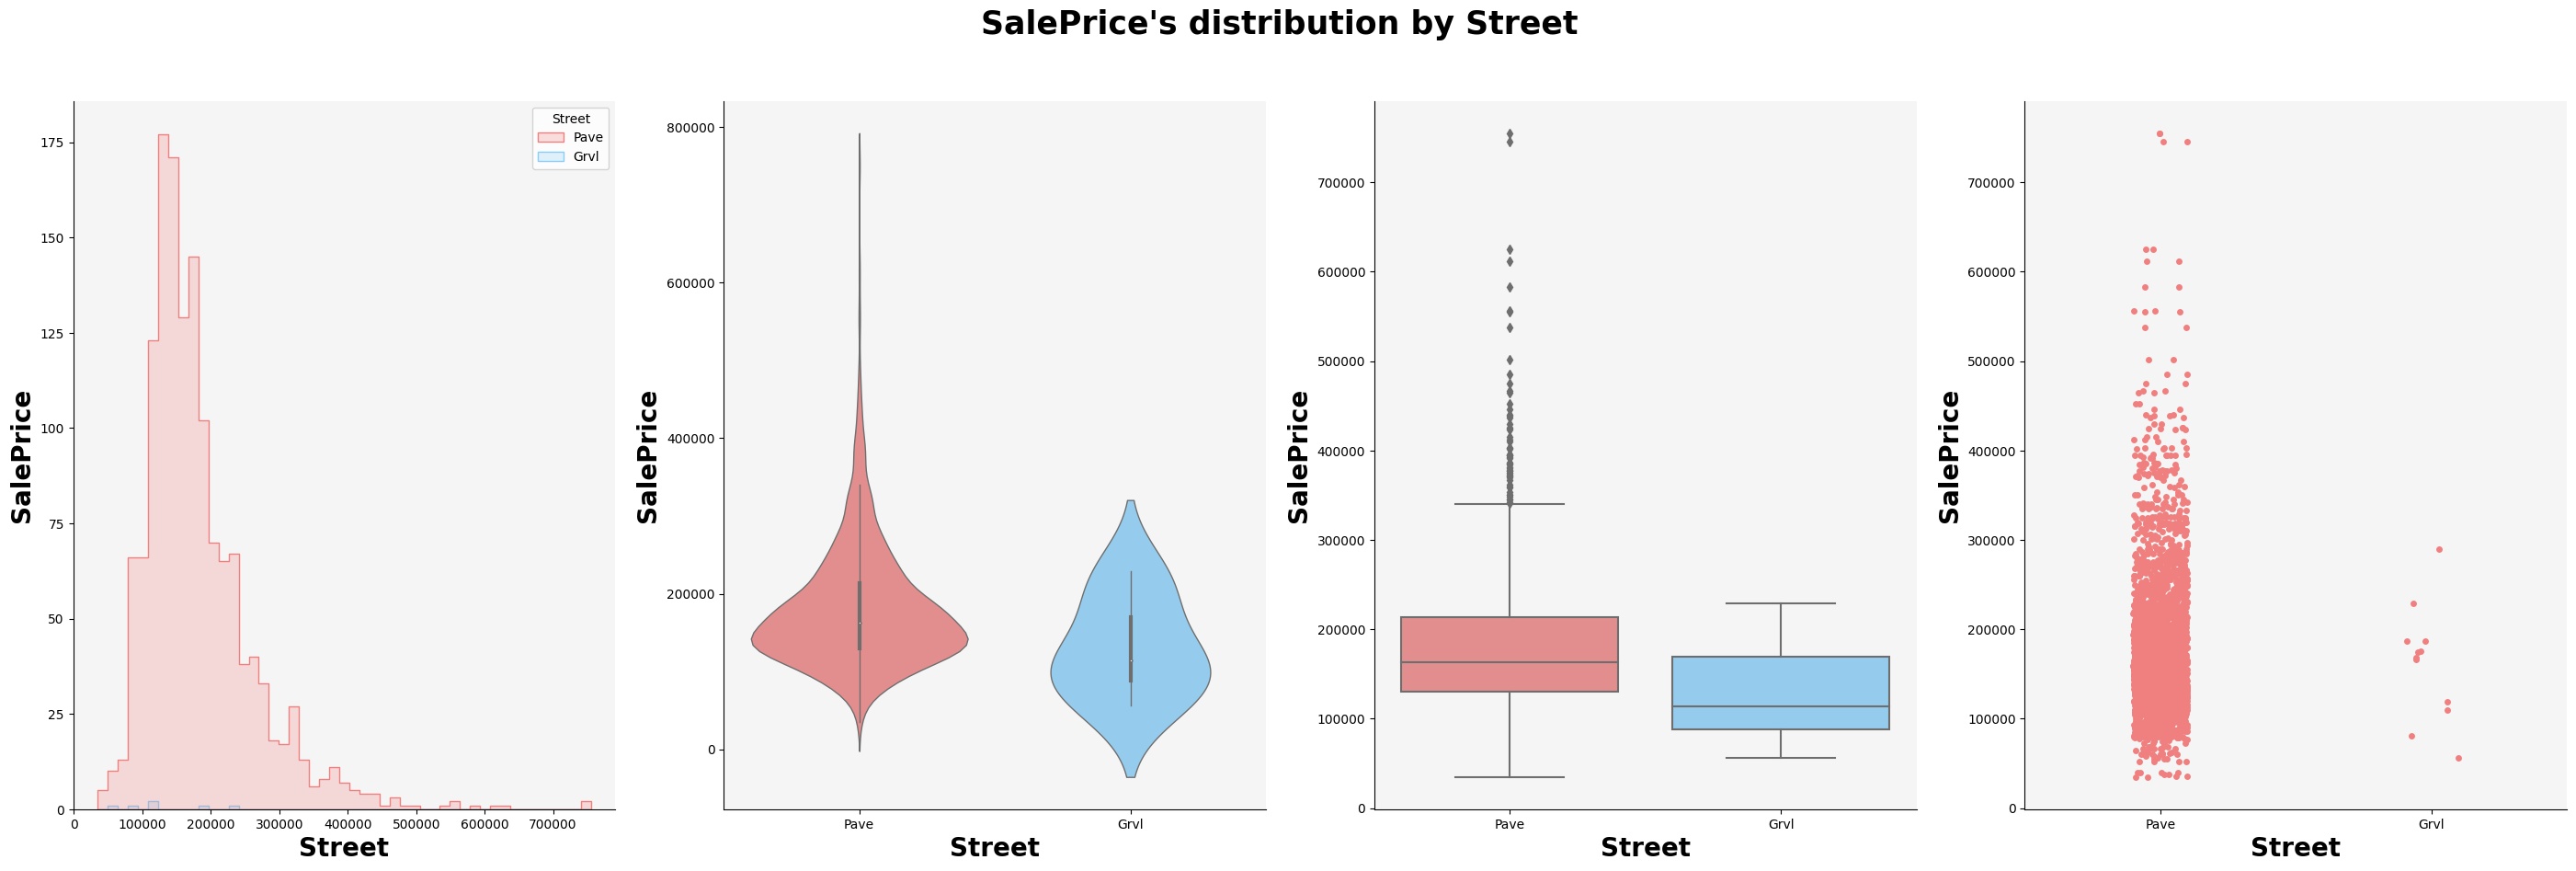

In [22]:
continuous_dist(all_data, "Street", "SalePrice")


## 歪みの確認

In [23]:
categorical_list = []
numerical_list = []
for i in all_data.columns.tolist():
    if all_data[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 43
Number of numerical features: 38


In [24]:
num_to_cat = []

#### Id ####
Skewness : 0.0
Kurtosis : -1.2000000000000002


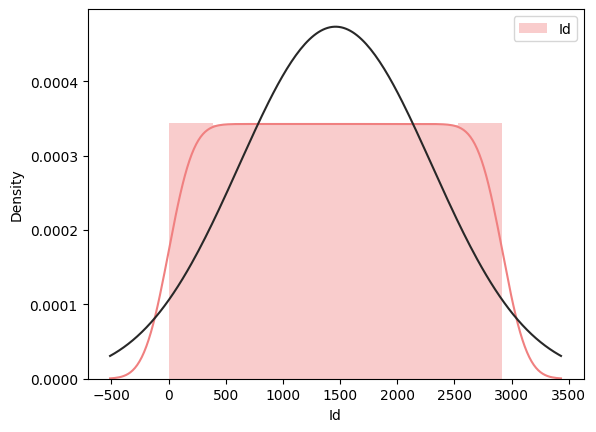

In [25]:
col = numerical_list[0]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
num_to_cat.append(col)

#### MSSubClass ####
Skewness : 1.3761646373261713
Kurtosis : 1.4578274774335522


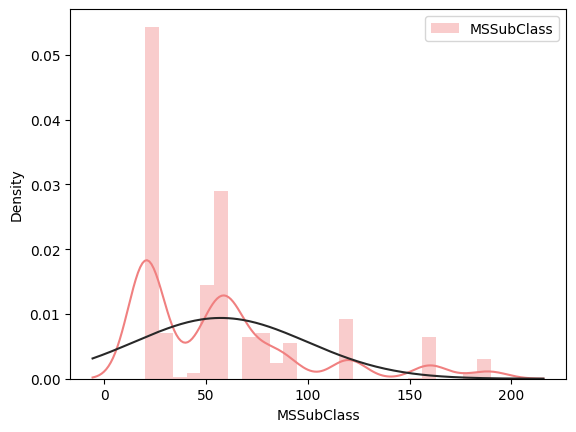

In [26]:
col = numerical_list[1]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
num_to_cat.append(col)

#### LotFrontage ####
Skewness : 1.5032778146412304
Kurtosis : 11.295920645765037


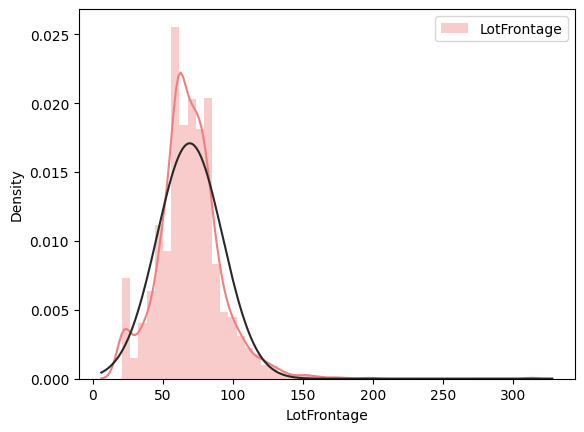

In [27]:
col = numerical_list[2]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)

#### LotArea ####
Skewness : 12.829024853018762
Kurtosis : 264.95231013978935


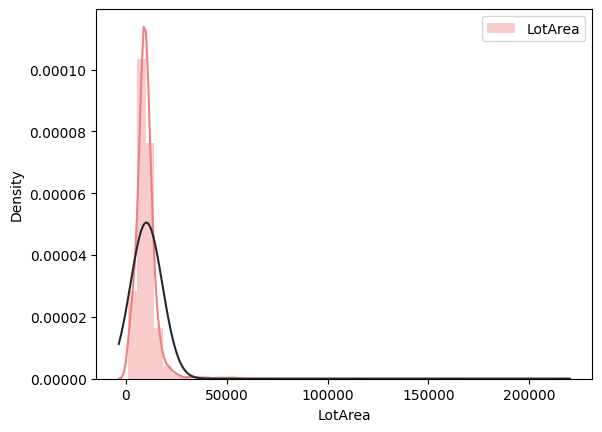

In [28]:
col = numerical_list[3]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)

#### OverallQual ####
Skewness : 0.19721180528040133
Kurtosis : 0.06721935990514183


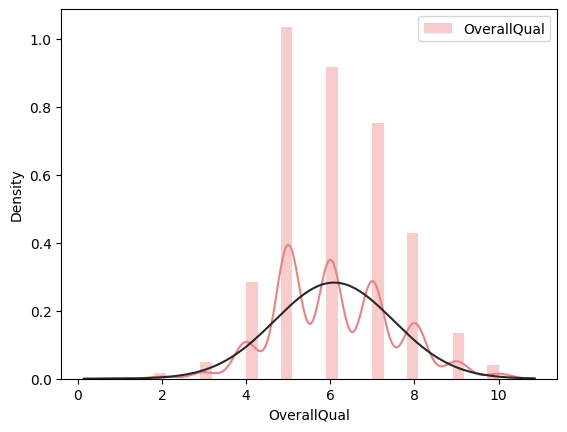

In [29]:
col = numerical_list[4]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### OverallCond ####
Skewness : 0.5706053117352524
Kurtosis : 1.4794473338247043


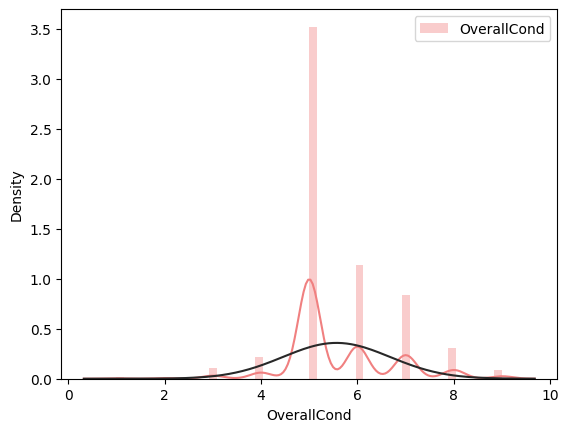

In [30]:
col = numerical_list[5]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### YearBuilt ####
Skewness : -0.6001139748696814
Kurtosis : -0.5113172970570274


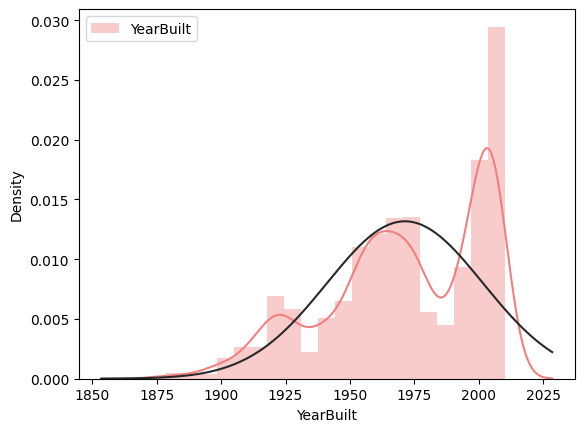

In [31]:
col = numerical_list[6]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### YearRemodAdd ####
Skewness : -0.45125229728739846
Kurtosis : -1.3464313917613444


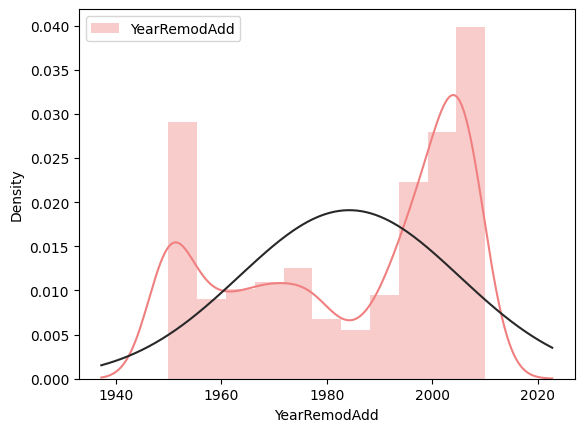

In [32]:
col = numerical_list[7]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### MasVnrArea ####
Skewness : 2.6025885122682517
Kurtosis : 9.254343333170063


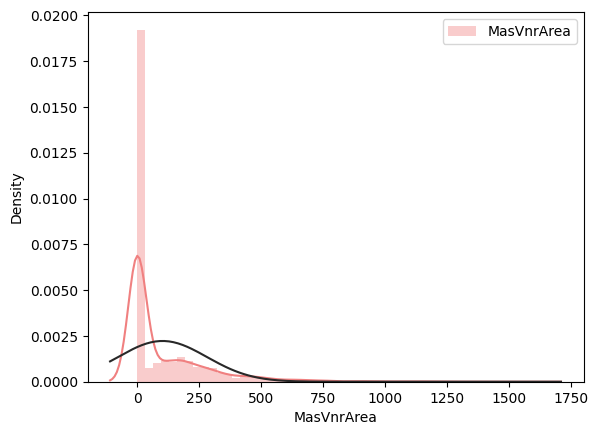

In [33]:
# 石壁の面積
col = numerical_list[8]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### BsmtFinSF1 ####
Skewness : 1.425722287785458
Kurtosis : 6.904832097242281


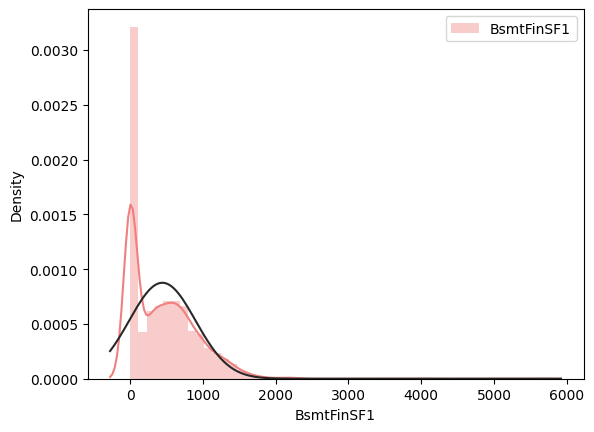

In [34]:
col = numerical_list[9]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### BsmtFinSF2 ####
Skewness : 4.1474557017396885
Kurtosis : 18.83653973071838


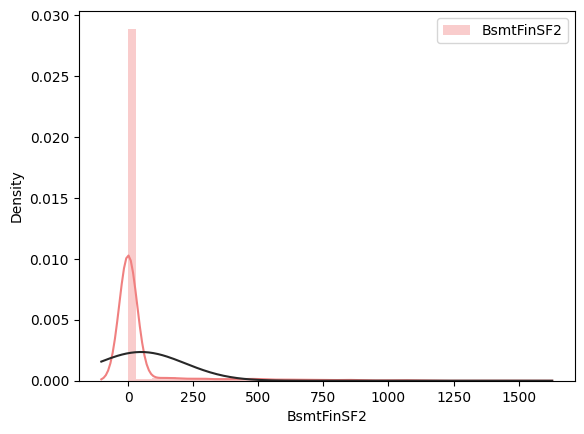

In [35]:
# 基礎２の大きさ
col = numerical_list[10]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### BsmtUnfSF ####
Skewness : 0.9198236977423032
Kurtosis : 0.4036169062515933


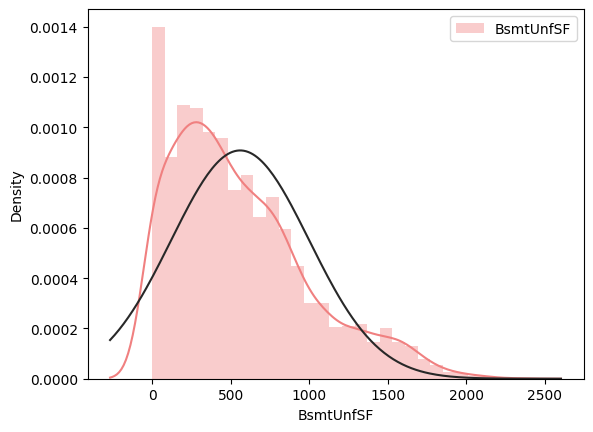

In [36]:
col = numerical_list[11]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### TotalBsmtSF ####
Skewness : 1.1628824745982715
Kurtosis : 9.151099191365313


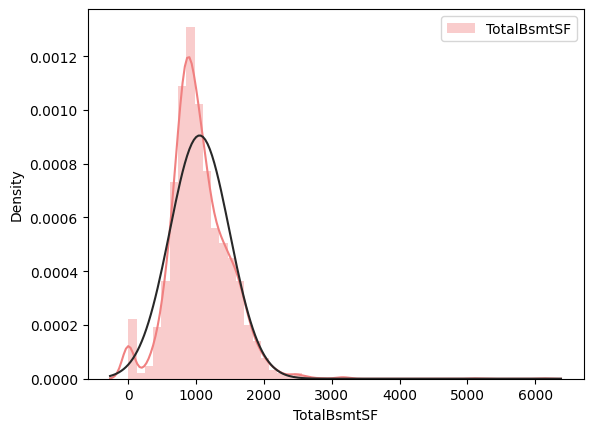

In [37]:
col = numerical_list[12]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### 1stFlrSF ####
Skewness : 1.4703601055379227
Kurtosis : 6.956479038030847


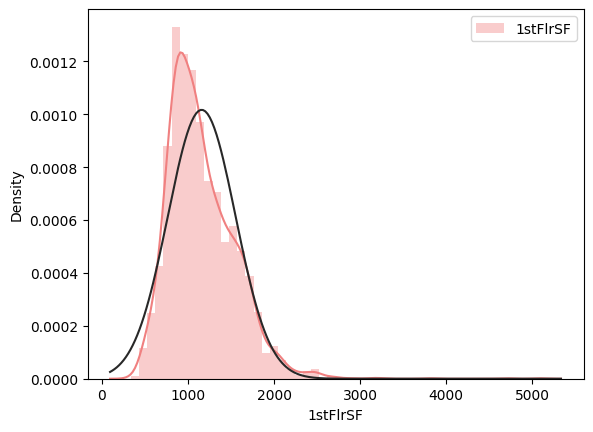

In [38]:
col = numerical_list[13]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### 2ndFlrSF ####
Skewness : 0.8621178325657642
Kurtosis : -0.4222606698937579


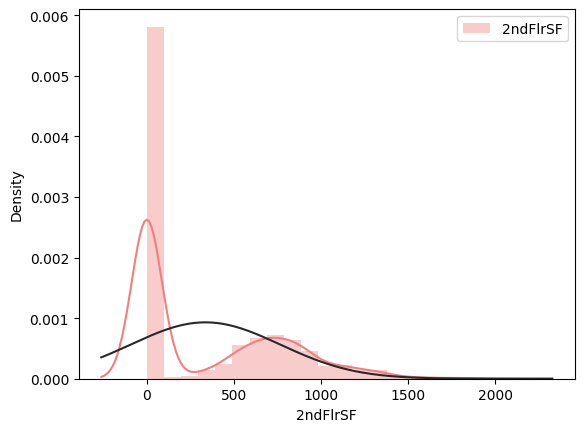

In [39]:
# 2階の広さ
col = numerical_list[14]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### LowQualFinSF ####
Skewness : 12.094977192517302
Kurtosis : 174.93281241177277


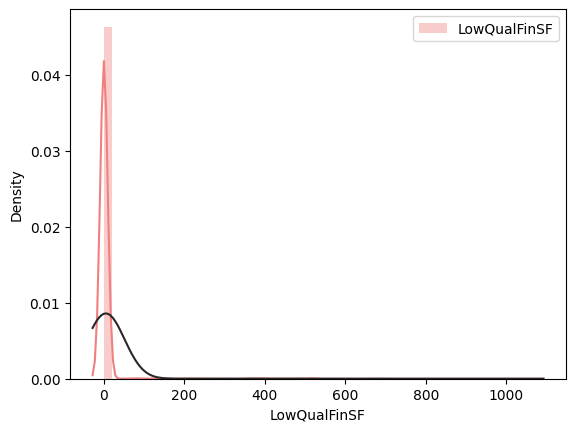

In [40]:
# 低品質の床の面積
col = numerical_list[15]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

# 実際はカテゴリ変数なので移動させる
# num_to_cat.append(col)
# num_to_cat.remove(col)
# num_to_cat

#### GrLivArea ####
Skewness : 1.2700104075191514
Kurtosis : 4.121603735289667


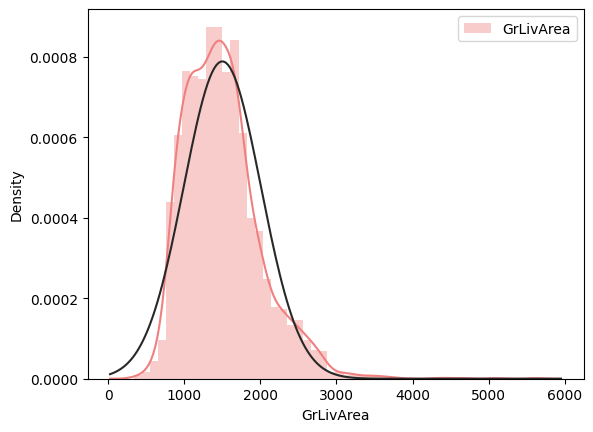

In [41]:
col = numerical_list[16]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### BsmtFullBath ####
Skewness : 0.6240621985365326
Kurtosis : -0.7356934432656019


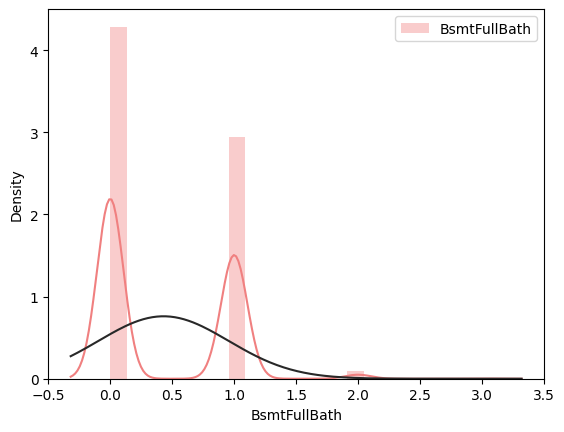

In [42]:
# 風呂の数
col = numerical_list[17]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### BsmtHalfBath ####
Skewness : 3.9320182078879196
Kurtosis : 14.848079309450544


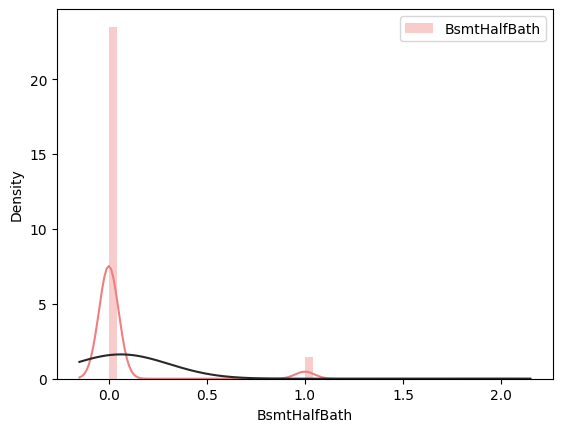

In [43]:
col = numerical_list[18]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### FullBath ####
Skewness : 0.16769191818882379
Kurtosis : -0.5381293607434401


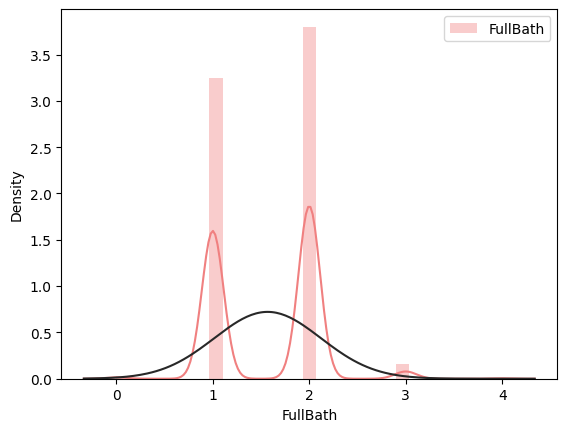

In [44]:
col = numerical_list[19]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### HalfBath ####
Skewness : 0.6949236492716564
Kurtosis : -1.0334464798987986


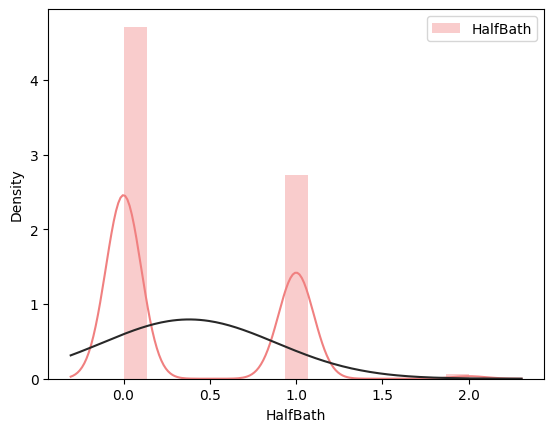

In [45]:
col = numerical_list[20]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### BedroomAbvGr ####
Skewness : 0.32649214927079917
Kurtosis : 1.9414037478968682


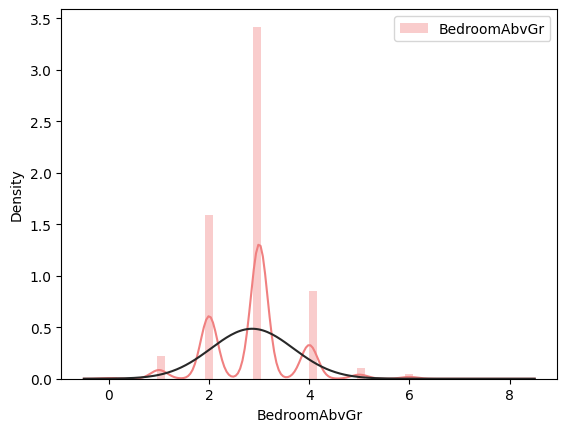

In [46]:
# ベッドルームの個数
col = numerical_list[21]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### KitchenAbvGr ####
Skewness : 4.304466641562935
Kurtosis : 19.77793659070052


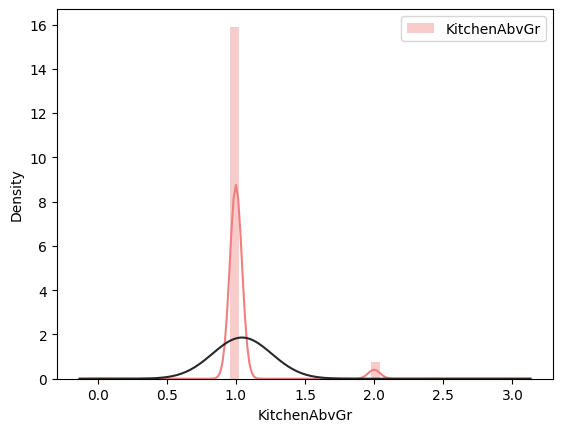

In [47]:
# キッチンの個数
col = numerical_list[22]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### TotRmsAbvGrd ####
Skewness : 0.7587568676624701
Kurtosis : 1.169063585207879


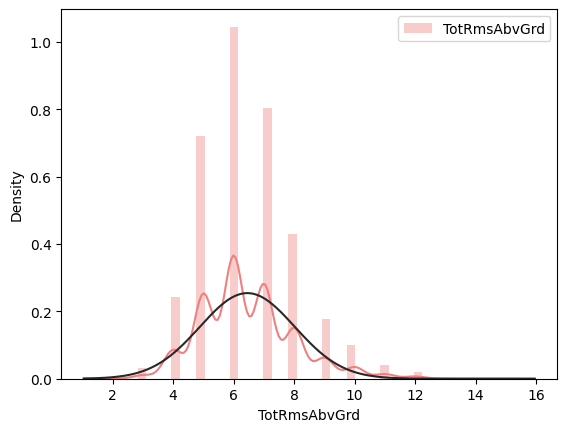

In [48]:
# トータルの部屋の数
col = numerical_list[23]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### Fireplaces ####
Skewness : 0.733871770878103
Kurtosis : 0.07642384075687625


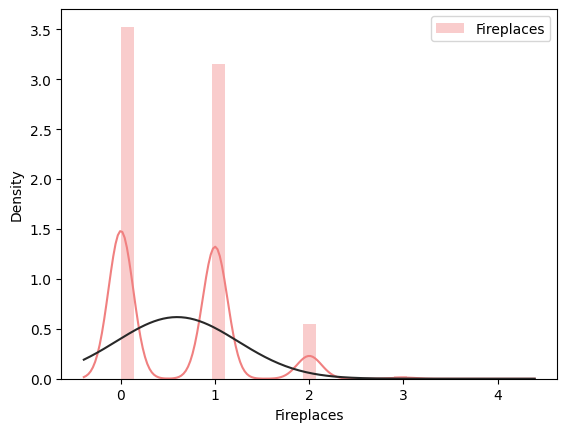

In [49]:
col = numerical_list[24]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### GarageYrBlt ####
Skewness : -0.38215016096981613
Kurtosis : 1.8098447176277452


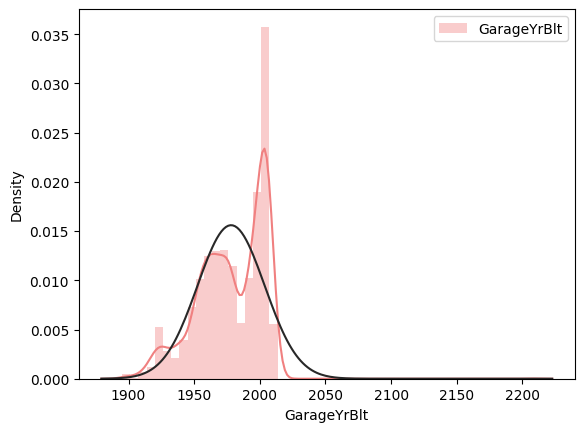

In [50]:
col = numerical_list[25]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### GarageCars ####
Skewness : -0.21837276655710502
Kurtosis : 0.2381978193292893


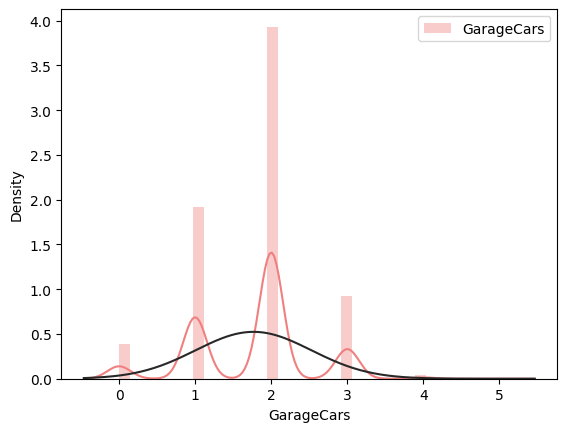

In [51]:
col = numerical_list[26]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### GarageArea ####
Skewness : 0.24130051733383068
Kurtosis : 0.939782905422236


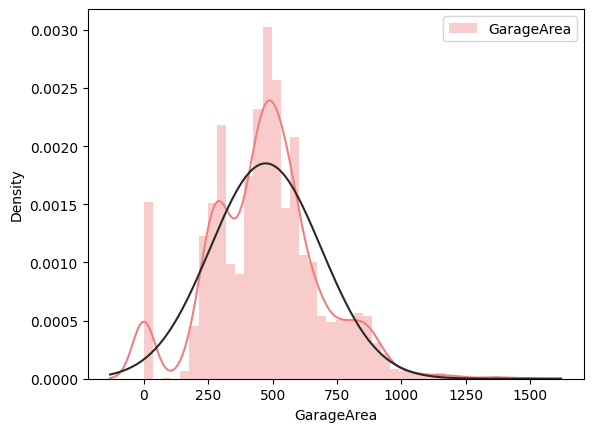

In [52]:
col = numerical_list[27]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### WoodDeckSF ####
Skewness : 1.8433802126628294
Kurtosis : 6.741550189823774


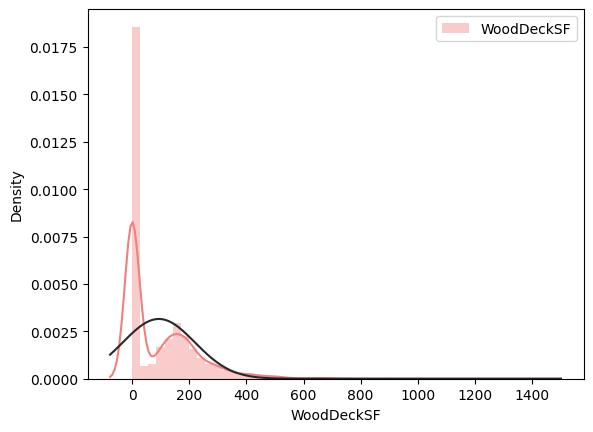

In [53]:
# ウッドデッキの広さ
col = numerical_list[28]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### OpenPorchSF ####
Skewness : 2.5364173160468444
Kurtosis : 10.937352524991375


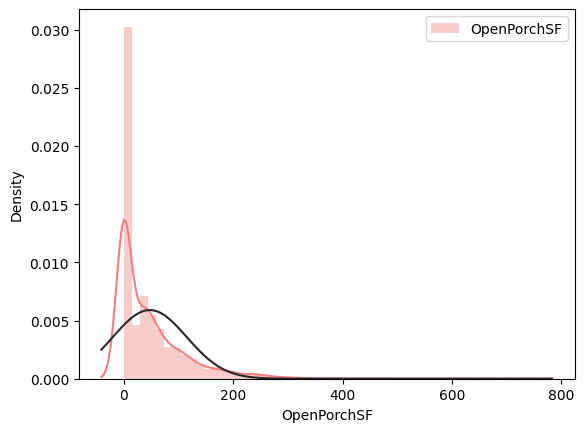

In [54]:
# オープンポーチ（玄関前のスペース）の広さ
col = numerical_list[29]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### EnclosedPorch ####
Skewness : 4.005950070504265
Kurtosis : 28.377908922009446


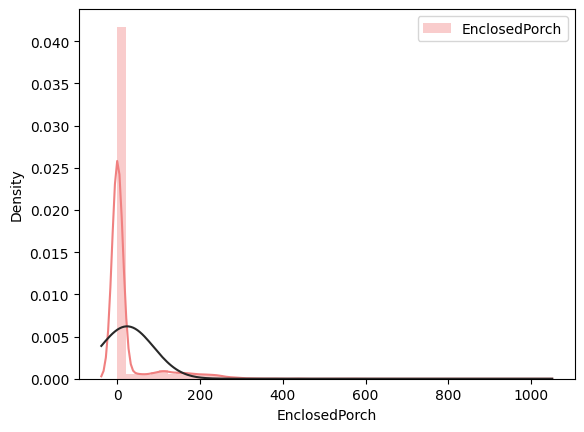

In [55]:
# エンクローズドポーチ（日向ぼっこできそうな屋内スペース）の広さ
col = numerical_list[30]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### 3SsnPorch ####
Skewness : 11.381914394786643
Kurtosis : 149.4098342664387


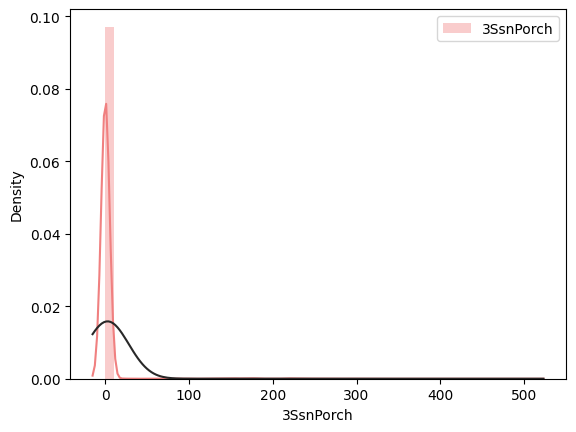

In [56]:
# 3シーズンに対応しているエンクローズドポーチの広さ
col = numerical_list[31]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### ScreenPorch ####
Skewness : 3.948723141292199
Kurtosis : 17.77670360587794


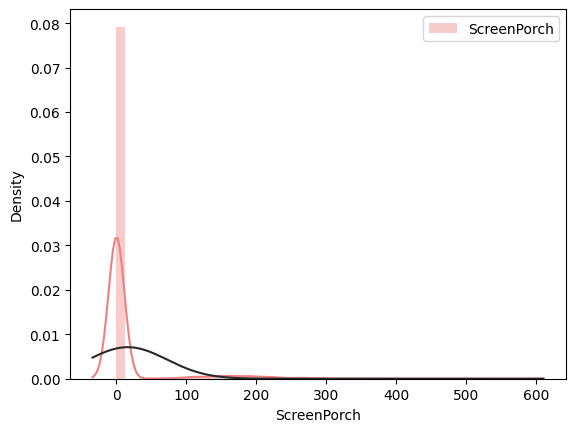

In [57]:
col = numerical_list[32]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### PoolArea ####
Skewness : 16.9070172435751
Kurtosis : 298.6331435760181


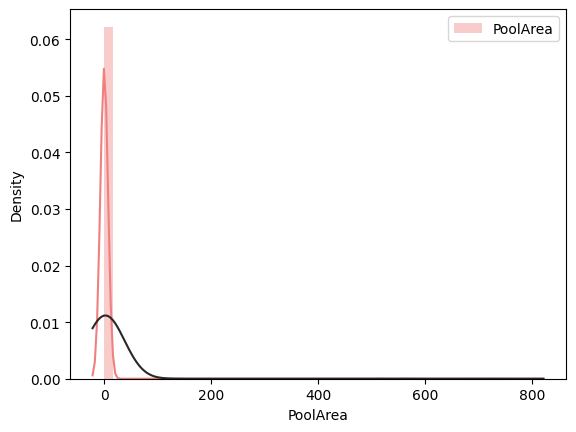

In [58]:
col = numerical_list[33]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### MiscVal ####
Skewness : 21.958480324447216
Kurtosis : 564.0745817668892


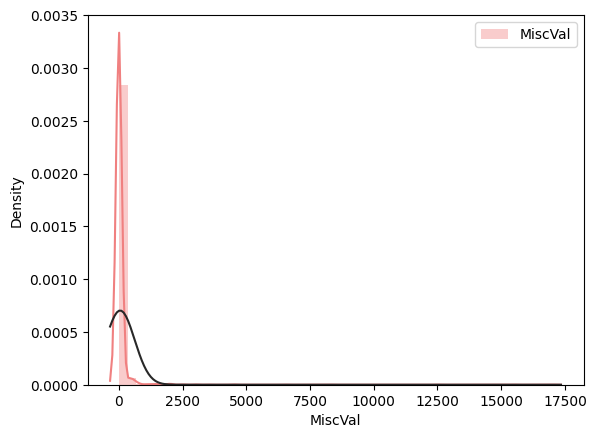

In [59]:
# MiscFeatureで指定されている設備の金額
col = numerical_list[34]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### MoSold ####
Skewness : 0.19598466898916275
Kurtosis : -0.4543365880455785


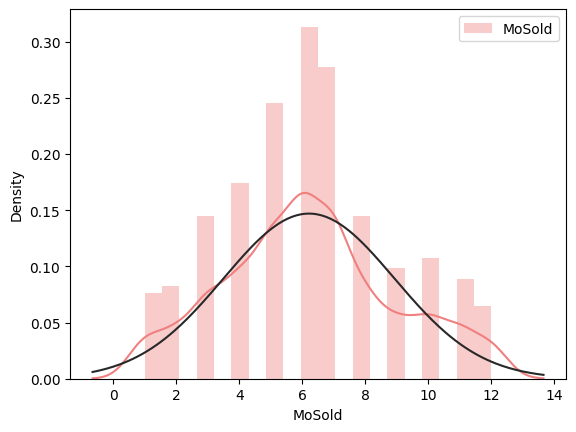

In [60]:
col = numerical_list[35]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### YrSold ####
Skewness : 0.13246689568568673
Kurtosis : -1.1551465584406364


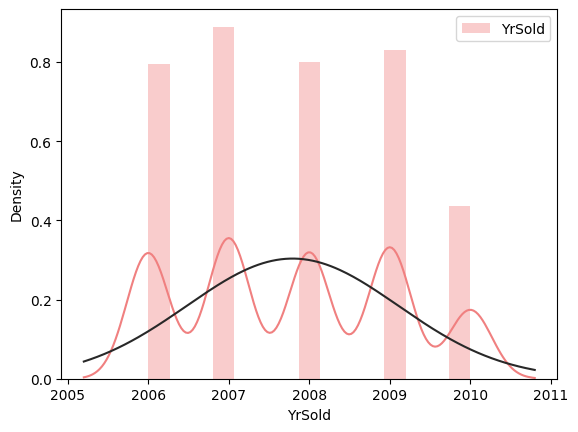

In [61]:
col = numerical_list[36]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

#### SalePrice ####
Skewness : 1.8828757597682129
Kurtosis : 6.5362818600645305


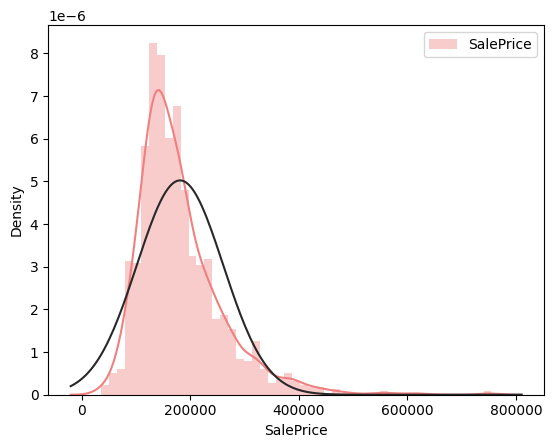

In [62]:
col = numerical_list[37]
print(f"#### {col} ####")
sns.distplot(all_data[col] , fit=norm, label=col);
print("Skewness :", all_data[col].skew())
print("Kurtosis :", all_data[col].kurt())
plt.legend()
plt.show()

In [63]:
# numericalに誤分類されていたcategoricalを移動させる
for col in num_to_cat:
  categorical_cols.append(col)
  numerical_cols.remove(col)
print(len(categorical_cols))
print(len(numerical_cols))

45
36


In [64]:
numerical_cols.remove("SalePrice")

## 欠損値の補完

<Axes: >

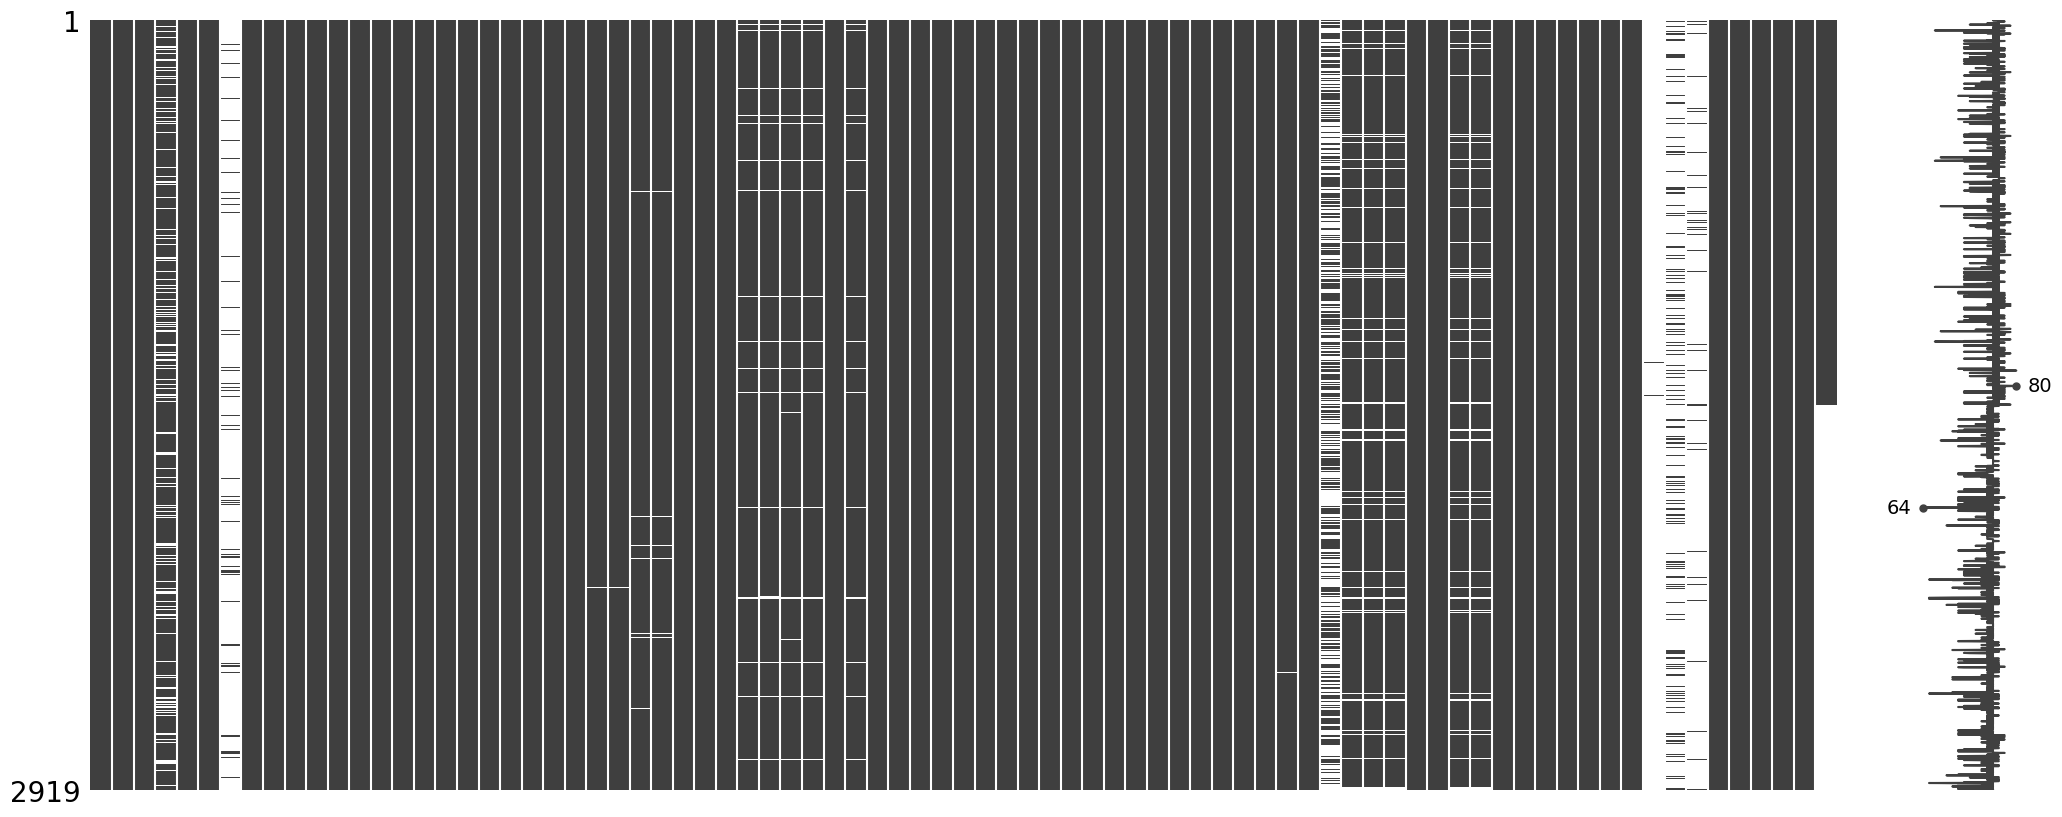

In [65]:
# Impute前のnumerical_cols
msno.matrix(all_data[numerical_cols])

In [67]:
all_data[numerical_cols] = SimpleImputer(strategy='median').fit_transform(all_data[numerical_cols])

<Axes: >

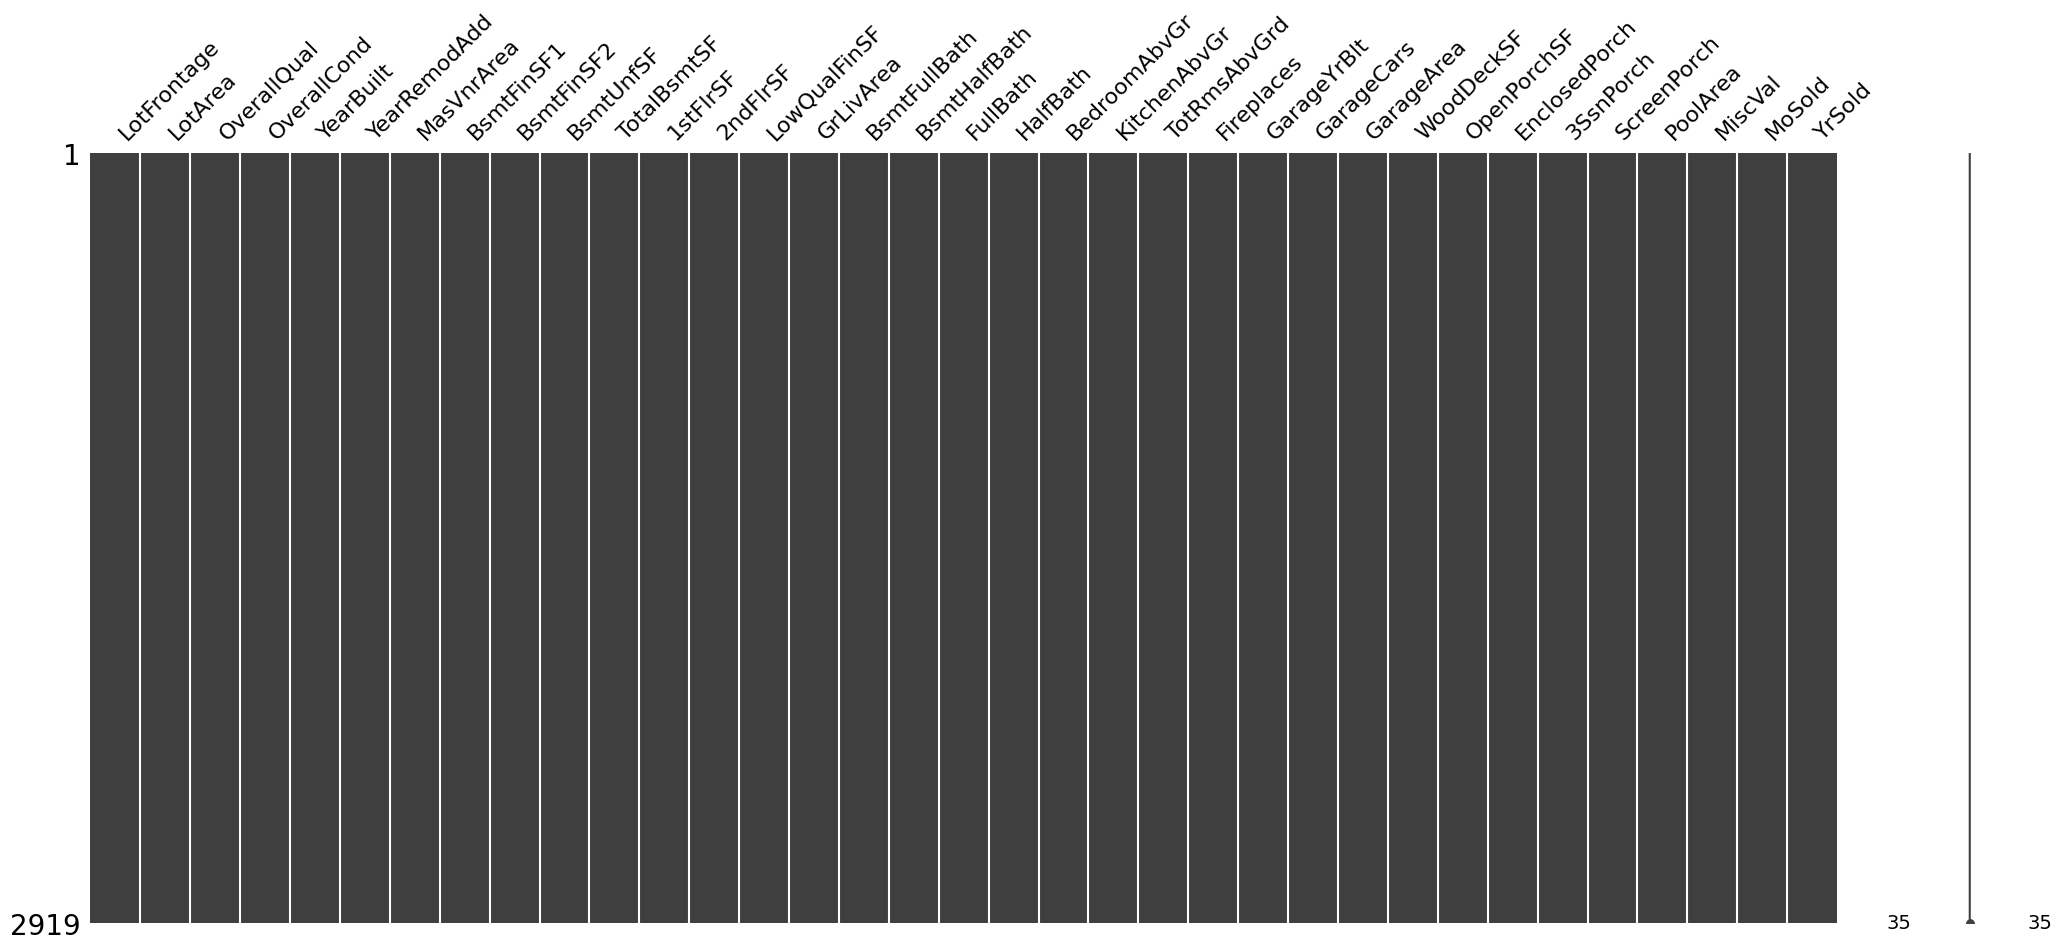

In [70]:
# Imputeあとのnumerical_cols
msno.matrix(all_data[numerical_cols])

## BoxCox変換で歪みを補正

In [71]:
# Check the skew of all numerical features
skewed_feats = all_data[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[skewness.abs() > 0.75]
skewness.dropna(inplace=True)
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


Skew in numerical features: 

There are 21 skewed numerical features to Box Cox transform


In [72]:
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

df_tmp = all_data.copy()
skewed_features = skewness.index.copy()
df_tmp[skewed_features] = SimpleImputer(strategy='median').fit_transform(df_tmp[skewed_features])

for i in skewed_features:
  print(i)
  df_tmp[i] = boxcox1p(df_tmp[i], boxcox_normmax(df_tmp[i] + 1))

MiscVal
PoolArea
LotArea
LowQualFinSF
3SsnPorch
KitchenAbvGr
BsmtFinSF2
EnclosedPorch
ScreenPorch
BsmtHalfBath
MasVnrArea
OpenPorchSF
WoodDeckSF
LotFrontage
1stFlrSF
BsmtFinSF1
GrLivArea
TotalBsmtSF
BsmtUnfSF
2ndFlrSF
TotRmsAbvGrd


## BoxCox変換後の分布を確認

#### MiscVal ####
Skewness : 5.242588857559474
Kurtosis : 26.389684402031666


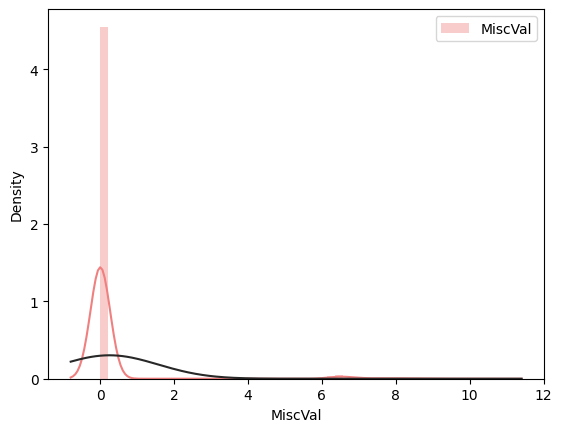

#### PoolArea ####
Skewness : 14.99369968569581
Kurtosis : 223.846889451027


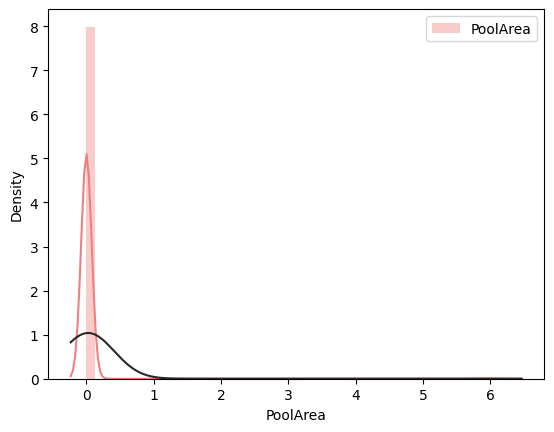

#### LotArea ####
Skewness : -0.13547037457611832
Kurtosis : 4.523488077881234


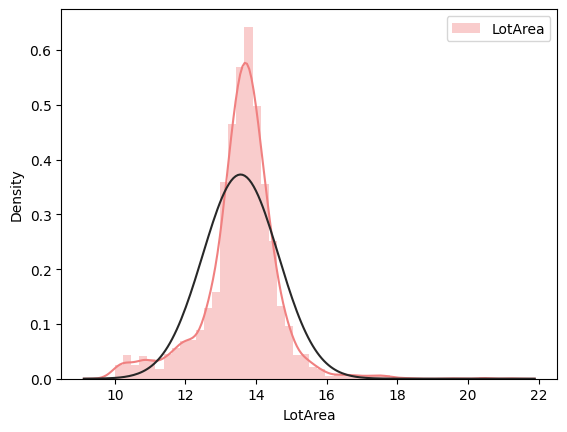

#### LowQualFinSF ####
Skewness : 8.499970977275645
Kurtosis : 70.95514393362635


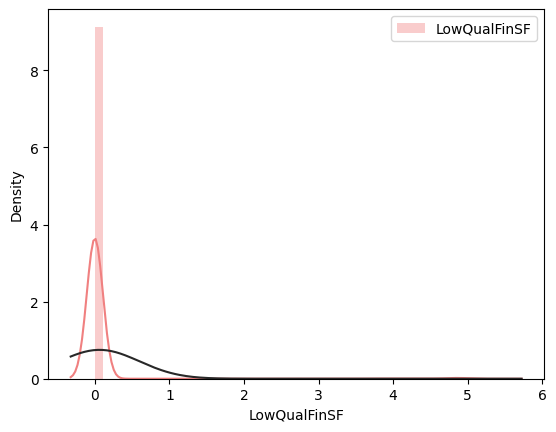

#### 3SsnPorch ####
Skewness : 8.869702674256079
Kurtosis : 77.50353085931557


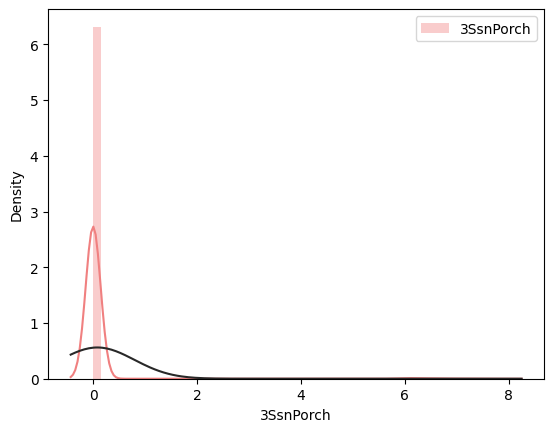

#### KitchenAbvGr ####
Skewness : 3.7818397708386944
Kurtosis : 19.439470168599843


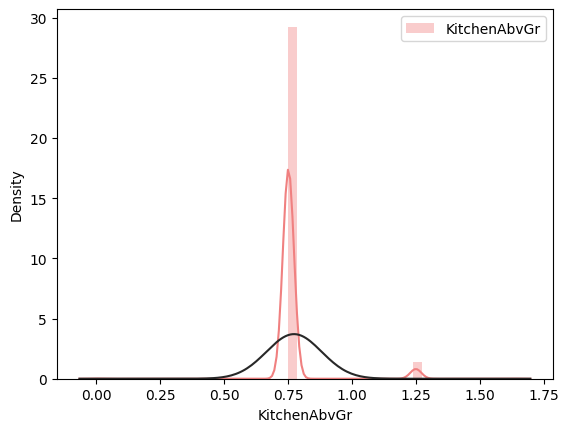

#### BsmtFinSF2 ####
Skewness : 2.5807939152011747
Kurtosis : 5.041479339732613


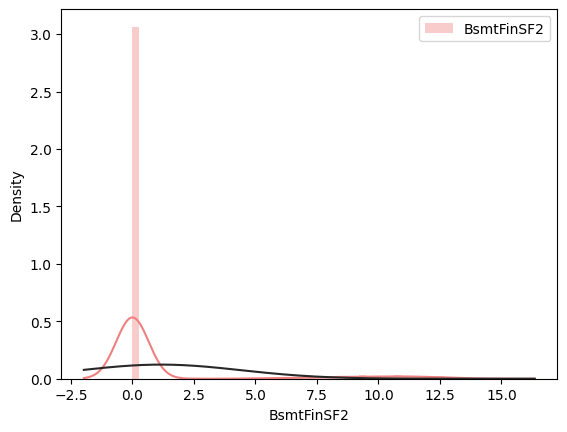

#### EnclosedPorch ####
Skewness : 2.1512628119690533
Kurtosis : 3.1079873688191046


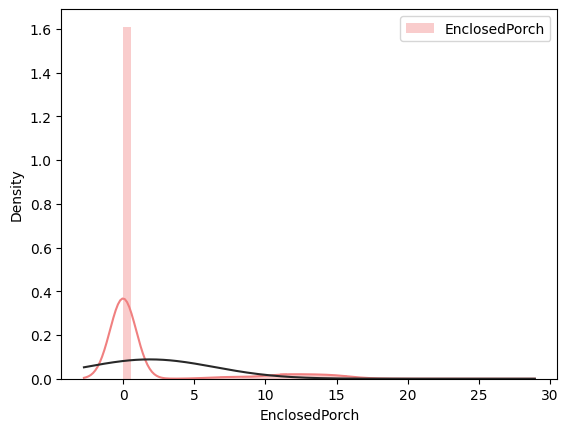

#### ScreenPorch ####
Skewness : 3.155532834585486
Kurtosis : 8.623478113405167


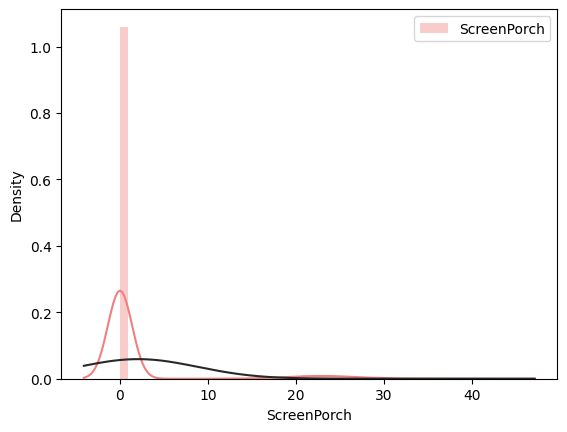

#### BsmtHalfBath ####
Skewness : 3.7829037733374893
Kurtosis : 12.68197539593082


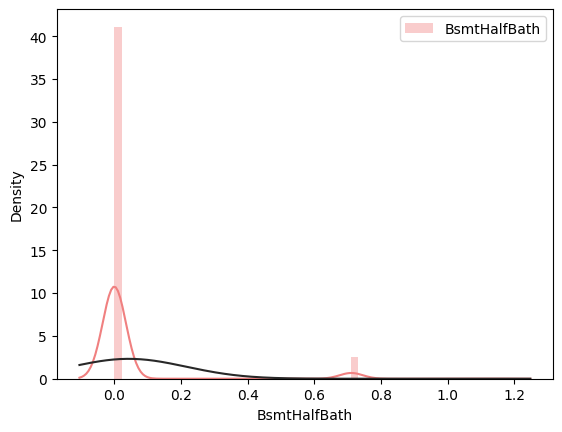

#### MasVnrArea ####
Skewness : 0.9768558844115804
Kurtosis : -0.30983673383839827


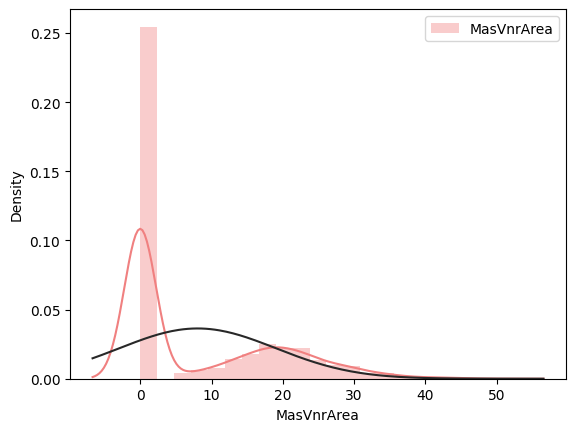

#### OpenPorchSF ####
Skewness : 0.6213446534464511
Kurtosis : -0.4654013527396783


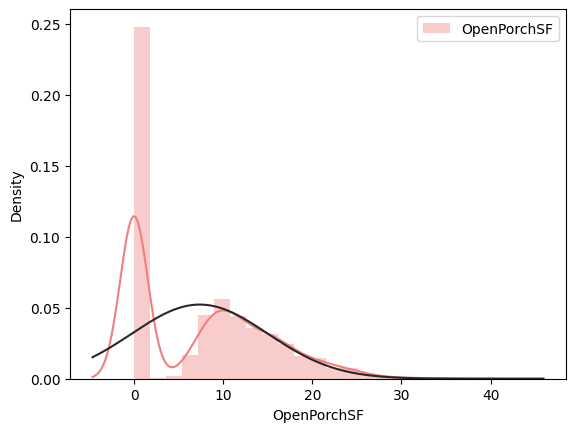

#### WoodDeckSF ####
Skewness : 0.7851717798663728
Kurtosis : -0.19256755144004378


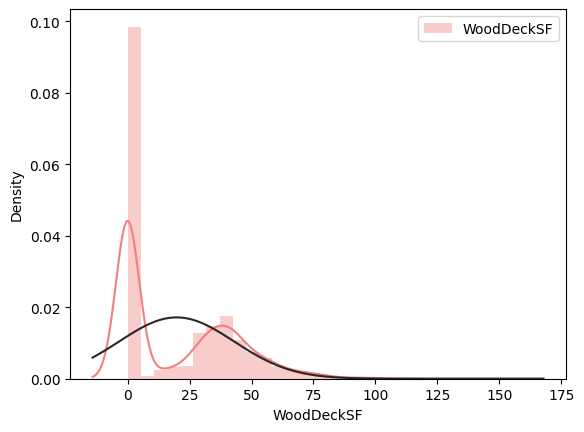

#### LotFrontage ####
Skewness : 0.05111263189123884
Kurtosis : 3.7644409756890678


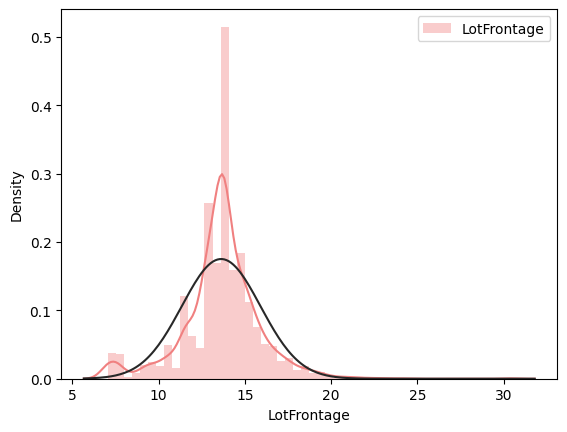

#### 1stFlrSF ####
Skewness : -0.011616599060629113
Kurtosis : 0.12921571994844516


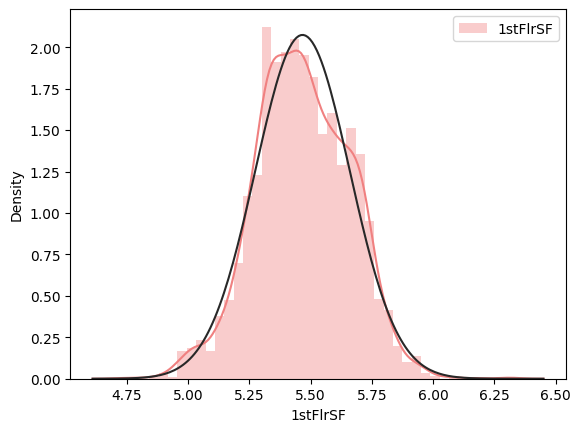

#### BsmtFinSF1 ####
Skewness : 0.3744705947682849
Kurtosis : -0.3666190629356674


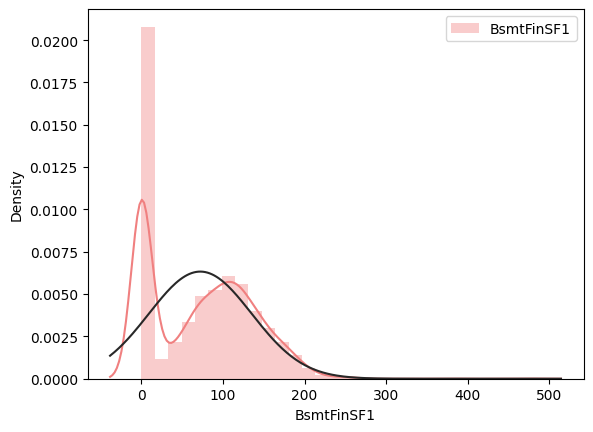

#### GrLivArea ####
Skewness : 0.00485078986915018
Kurtosis : 0.21150452307261913


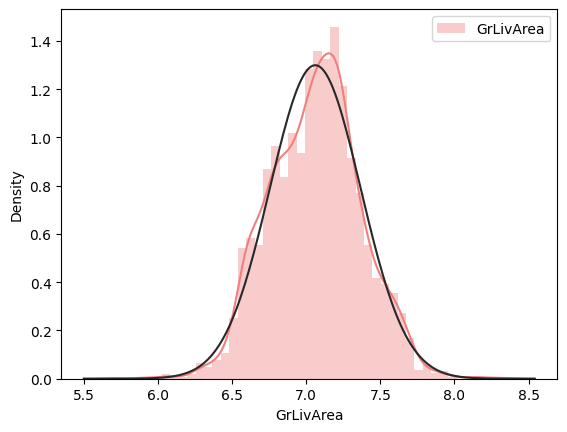

#### TotalBsmtSF ####
Skewness : 0.37016513262841677
Kurtosis : 4.705259987461486


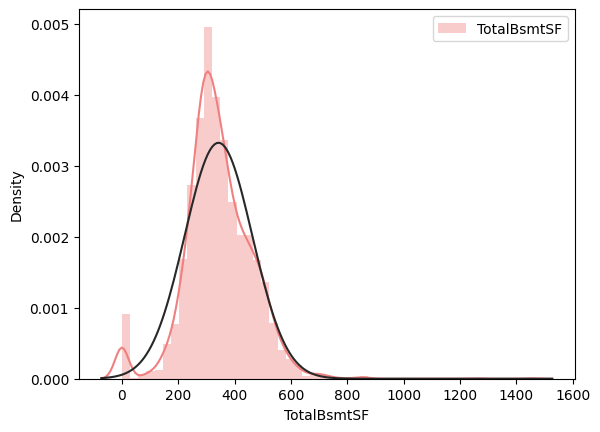

#### BsmtUnfSF ####
Skewness : 0.05405496292895827
Kurtosis : -0.45248715757339975


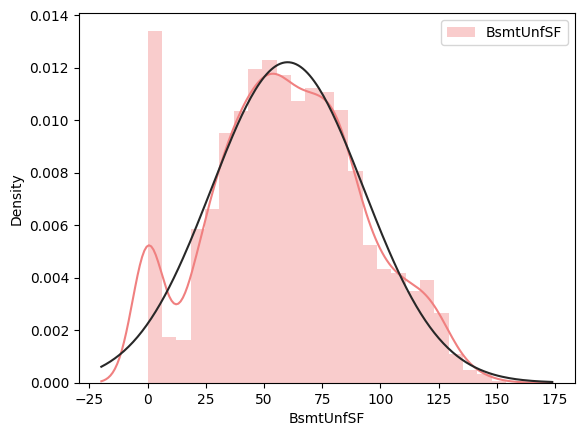

#### 2ndFlrSF ####
Skewness : 0.8949963020191737
Kurtosis : -0.3082411064261583


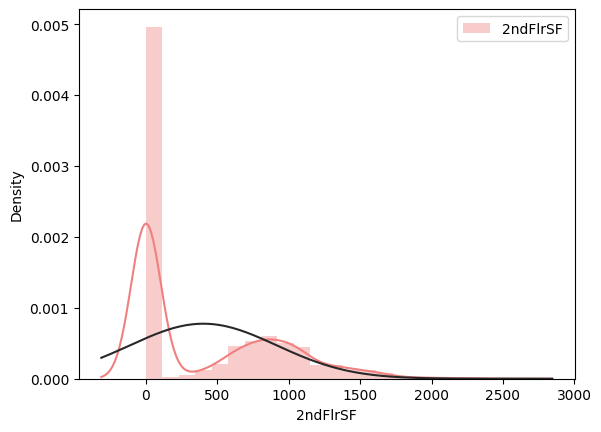

#### TotRmsAbvGrd ####
Skewness : 0.047249851005081396
Kurtosis : 0.3187552165578711


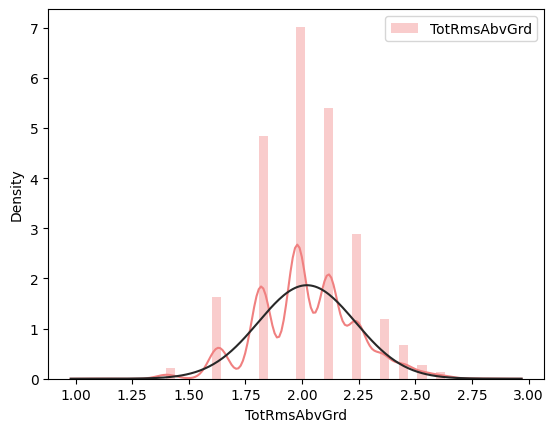

In [73]:
for col in skewed_features:
  print(f"#### {col} ####")
  sns.distplot(df_tmp[col] , fit=norm, label=col);
  print("Skewness :", df_tmp[col].skew())
  print("Kurtosis :", df_tmp[col].kurt())
  plt.legend()
  plt.show()

In [74]:
# df_tmp の各列の値をall_dataに反映させる
for col in df_tmp.columns:
  all_data[col] = df_tmp[col]

## カテゴリ変数はラベルエンコーディングする（all_data_leを利用する）

In [75]:
all_data_le = all_data.copy()
for col in categorical_cols:
    if col != 'SalePrice':
        le = LabelEncoder()
        all_data_le[col] = le.fit_transform(all_data_le[col])
all_data_le.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,5,3,13.360621,13.424520,1,2,3,3,0,...,0.0,3,4,4,0.0,2.0,2008.0,8,4,208500.0
1,1,0,3,14.945970,13.694527,1,2,3,3,0,...,0.0,3,4,4,0.0,5.0,2007.0,8,4,181500.0
2,2,5,3,13.691701,14.034133,1,2,0,3,0,...,0.0,3,4,4,0.0,9.0,2008.0,8,4,223500.0
3,3,6,3,12.790819,13.683421,1,2,0,3,0,...,0.0,3,4,4,0.0,2.0,2006.0,8,0,140000.0
4,4,5,3,15.342157,14.550142,1,2,0,3,0,...,0.0,3,4,4,0.0,12.0,2008.0,8,4,250000.0


## StratifiedKFoldを使ってテストデータを準備する

In [90]:
target = "SalePrice"
feature_cols = all_data_le.columns.drop(target)

X = all_data_le.iloc[:train.shape[0]][feature_cols]
y = all_data_le.iloc[:train.shape[0]][target]
# n_splitsでKの数を指定
skf = StratifiedKFold(n_splits=5)

# 下記を実行することで分割できる
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  X_train = X.iloc[train_index, :]
  y_train = y.iloc[train_index]
  X_val = X.iloc[test_index, :]
  y_val = y.iloc[test_index]

In [86]:
# ちゃんと分割できている
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1460, 80)
(1460,)
(1168, 80)
(1168,)
(292, 80)
(292,)


## 特徴量の選択

### Fileter method

#### Pearson Correlation

相関の高い特徴量を削除する

In [87]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [119]:
df_cor = pd.DataFrame(columns=X_train.columns)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  X_train = X.iloc[train_index, :]
  y_train = y.iloc[train_index]
  X_val = X.iloc[test_index, :]
  y_val = y.iloc[test_index]

  # Feature selection method 固有の記述
  feature_name = X_train.columns.tolist()
  cor_support, cor_feature = cor_selector(X_train, y_train)
  print(f"K={i}", str(len(cor_feature)), 'selected features')
  row = pd.Series(cor_support, index=df_cor.columns)
  df_cor = df_cor.append(row, ignore_index=True)
  #固有の記述ここまで

df_cor

K=0 80 selected features
K=1 80 selected features
K=2 80 selected features
K=3 80 selected features
K=4 80 selected features


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


#### Mutual Infomartion

In [120]:
df_mi = pd.DataFrame(columns=X_train.columns)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  X_train = X.iloc[train_index, :]
  y_train = y.iloc[train_index]
  X_val = X.iloc[test_index, :]
  y_val = y.iloc[test_index]

  # Feature selection method 固有の記述
  selector = SelectKBest(mutual_info_regression, k=30)
  selector.fit(X_train, y_train)
  support = selector.get_support()
  feature = X_train.loc[:,support].columns.tolist()
  print(f"K={i}", str(len(feature)), 'selected features')
  row = pd.Series(support, index=df_mi.columns)
  df_mi = df_mi.append(row, ignore_index=True)
  #固有の記述ここまで

df_mi

K=0 30 selected features
K=1 30 selected features
K=2 30 selected features
K=3 30 selected features
K=4 30 selected features


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,False,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Chi2

In [122]:
df_chi = pd.DataFrame(columns=X_train.columns)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  X_train = X.iloc[train_index, :]
  y_train = y.iloc[train_index]
  X_val = X.iloc[test_index, :]
  y_val = y.iloc[test_index]

  # Feature selection method 固有の記述
  selector = SelectKBest(chi2, k=30)
  selector.fit(MinMaxScaler().fit_transform(X_train), y_train) # X_trainにMinMaxを適用しているので注意
  support = selector.get_support()
  feature = X_train.loc[:,support].columns.tolist()
  print(f"K={i}", str(len(feature)), 'selected features')
  row = pd.Series(support, index=df_chi.columns)
  df_chi = df_chi.append(row, ignore_index=True)
  #固有の記述ここまで

df_chi

K=0 30 selected features
K=1 30 selected features
K=2 30 selected features
K=3 30 selected features
K=4 30 selected features


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,True,True,False,False,False,False,False,True,False,True,...,True,True,False,False,False,True,False,True,False,False
1,False,True,False,False,False,False,False,True,False,True,...,True,True,False,False,False,True,False,True,False,False
2,True,True,False,False,False,False,False,True,False,False,...,True,True,False,False,False,True,False,True,False,False
3,False,True,False,False,False,False,False,True,False,True,...,True,True,False,False,False,True,False,True,False,False
4,True,True,False,False,False,False,False,True,False,True,...,True,True,False,False,False,True,False,True,False,False


### Wrapper method

#### Logistic Regression

In [132]:
df_wr_lr = pd.DataFrame(columns=X_train.columns)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  X_train = X.iloc[train_index, :]
  y_train = y.iloc[train_index]
  X_val = X.iloc[test_index, :]
  y_val = y.iloc[test_index]

  # Feature selection method 固有の記述
  selector = RFE(estimator=LogisticRegression(), n_features_to_select=30, step=10, verbose=5)
  selector.fit(MinMaxScaler().fit_transform(X_train), y_train)

  support = selector.get_support()
  feature = X_train.loc[:,support].columns.tolist()
  print(str(len(feature)), 'selected features')
  row = pd.Series(support, index=df_wr_lr.columns)
  df_wr_lr = df_wr_lr.append(row, ignore_index=True)
  #固有の記述ここまで

df_wr_lr

Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected features
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected features
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected features
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected features
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected feat

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,True,True,False,False,False,False,False,True,True,False,...,False,False,False,True,False,False,True,True,False,False
1,True,True,False,False,False,False,False,True,True,False,...,False,False,False,True,False,False,True,True,False,False
2,True,True,False,False,False,False,False,True,True,False,...,False,False,False,True,False,False,True,True,False,False
3,True,True,False,False,False,False,False,True,True,False,...,False,False,False,True,False,False,True,True,False,False
4,True,True,False,False,False,False,False,True,True,False,...,False,False,False,True,False,False,True,True,False,False


#### LightGBM

In [131]:
df_wr_lgb = pd.DataFrame(columns=X_train.columns)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  X_train = X.iloc[train_index, :]
  y_train = y.iloc[train_index]
  X_val = X.iloc[test_index, :]
  y_val = y.iloc[test_index]

  # Feature selection method 固有の記述
  selector = RFE(estimator=lgb.LGBMRegressor(), n_features_to_select=30, step=10, verbose=5)
  selector.fit(MinMaxScaler().fit_transform(X_train), y_train)

  support = selector.get_support()
  feature = X_train.loc[:,support].columns.tolist()
  print(str(len(feature)), 'selected features')
  row = pd.Series(support, index=df_wr_lgb.columns)
  df_wr_lgb = df_wr_lgb.append(row, ignore_index=True)
  #固有の記述ここまで

df_wr_lgb

Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected features
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected features
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected features
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected features
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
30 selected feat

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,True,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
1,True,False,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
2,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
3,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,True,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True


### Embeded method

#### Logistic Regression

In [135]:
df_em_lr = pd.DataFrame(columns=X_train.columns)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  X_train = X.iloc[train_index, :]
  y_train = y.iloc[train_index]
  X_val = X.iloc[test_index, :]
  y_val = y.iloc[test_index]

  # Feature selection method 固有の記述
  selector = SelectFromModel(estimator=LogisticRegression(), threshold='1.25*median')
  selector.fit(MinMaxScaler().fit_transform(X_train), y_train)

  support = selector.get_support()
  feature = X_train.loc[:,support].columns.tolist()
  print(str(len(feature)), 'selected features')
  row = pd.Series(support, index=df_em_lr.columns)
  df_em_lr = df_em_lr.append(row, ignore_index=True)
  #固有の記述ここまで

df_em_lr

27 selected features
30 selected features
27 selected features
29 selected features
27 selected features


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,True,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,True,False,False
1,True,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,True,False,False
2,True,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,True,False,False
3,True,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,True,False,False
4,True,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,True,False,False


#### LightGBM

In [136]:
df_em_lgb = pd.DataFrame(columns=X_train.columns)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  X_train = X.iloc[train_index, :]
  y_train = y.iloc[train_index]
  X_val = X.iloc[test_index, :]
  y_val = y.iloc[test_index]

  # Feature selection method 固有の記述
  selector = SelectFromModel(estimator=lgb.LGBMRegressor(), threshold='1.25*median')
  selector.fit(MinMaxScaler().fit_transform(X_train), y_train)

  support = selector.get_support()
  feature = X_train.loc[:,support].columns.tolist()
  print(str(len(feature)), 'selected features')
  row = pd.Series(support, index=df_em_lgb.columns)
  df_em_lgb = df_em_lgb.append(row, ignore_index=True)
  #固有の記述ここまで

df_em_lgb

35 selected features
36 selected features
37 selected features
37 selected features
29 selected features


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,True,True,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
1,True,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
2,True,True,True,True,True,False,False,True,False,False,...,False,False,False,False,False,False,True,True,False,True
3,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
4,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True


#### RandomForest

In [138]:
df_em_rf = pd.DataFrame(columns=X_train.columns)
for i, (train_index, test_index) in enumerate(skf.split(X,y)):
  X_train = X.iloc[train_index, :]
  y_train = y.iloc[train_index]
  X_val = X.iloc[test_index, :]
  y_val = y.iloc[test_index]

  # Feature selection method 固有の記述
  selector = SelectFromModel(estimator=RandomForestRegressor(n_estimators=100), threshold='1.25*median')
  selector.fit(MinMaxScaler().fit_transform(X_train), y_train)

  support = selector.get_support()
  feature = X_train.loc[:,support].columns.tolist()
  print(str(len(feature)), 'selected features')
  row = pd.Series(support, index=df_em_rf.columns)
  df_em_rf = df_em_rf.append(row, ignore_index=True)
  #固有の記述ここまで

df_em_rf

33 selected features
37 selected features
35 selected features
36 selected features
35 selected features


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,True,False,False,True,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
1,True,False,True,True,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
2,True,False,True,True,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,False
4,True,False,True,True,True,False,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False


### 特徴量選択のためのスコア算出

In [145]:
df_list = [
    df_cor,
    df_mi,
    df_chi,
    df_wr_lr,
    df_wr_lgb,
    df_em_lr,
    df_em_lgb,
    df_em_rf
]

In [153]:
summary_df = pd.DataFrame({
    "Feature":X.columns,
    "Pearson":pd.Series(df_cor.mean(axis=0), index=X.columns),
    "Mutual Info":pd.Series(df_mi.mean(axis=0), index=X.columns),
    "Chi2":pd.Series(df_chi.mean(axis=0), index=X.columns),
    "Wrap-lr":pd.Series(df_wr_lr.mean(axis=0), index=X.columns),
    "Wrap-lgb":pd.Series(df_wr_lgb.mean(axis=0), index=X.columns),
    "Embedded-lr":pd.Series(df_em_lr.mean(axis=0), index=X.columns),
    "Embedded-lgb":pd.Series(df_em_lgb.mean(axis=0), index=X.columns),
    "Embedded-rf":pd.Series(df_em_rf.mean(axis=0), index=X.columns)
    })
# count the selected times for each feature
summary_df['Total'] = np.sum(summary_df, axis=1)
# display the top 100
summary_df = summary_df.sort_values(['Total','Feature'] , ascending=False)
summary_df.index = range(1, len(summary_df)+1)
summary_df.head(100)

,Feature,Pearson,Mutual Info,Chi2,Wrap-lr,Wrap-lgb,Embedded-lr,Embedded-lgb,Embedded-rf,Total
1,YearRemodAdd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
2,OpenPorchSF,1.0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,7.8
3,2ndFlrSF,1.0,1.0,1.0,0.2,1.0,1.0,1.0,1.0,7.2
4,Fireplaces,1.0,1.0,1.0,0.8,0.8,1.0,1.0,0.6,7.2
5,WoodDeckSF,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...
76,ExterCond,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
77,Condition2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78,BsmtFinType2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
79,BsmtCond,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


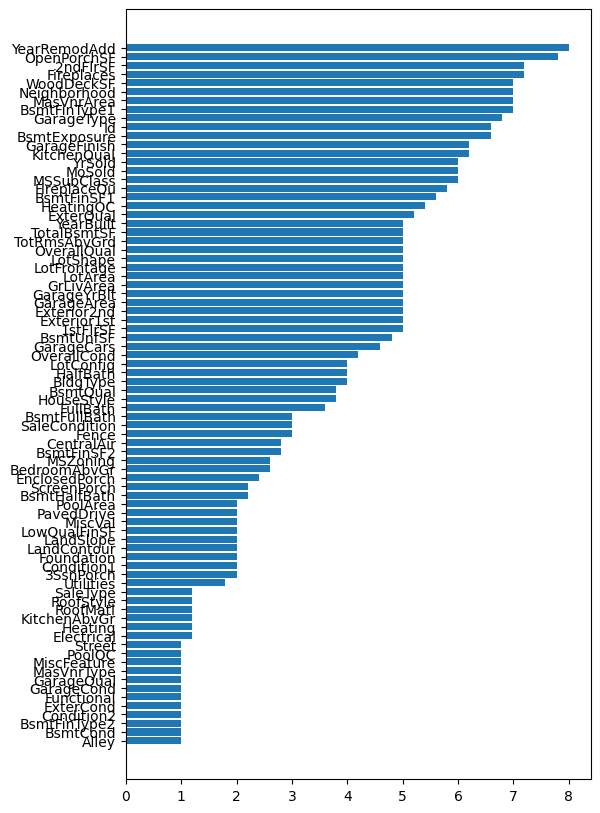

In [173]:
plt.figure(figsize=(6,10))
plt.barh(summary_df["Feature"], summary_df["Total"])
plt.gca().invert_yaxis()
plt.rcParams["font.size"] = 8

In [184]:
col = summary_df.columns.drop(["Feature", "Total"])[0]
col

Index(['Pearson', 'Mutual Info', 'Chi2', 'Wrap-lr', 'Wrap-lgb', 'Embedded-lr',
       'Embedded-lgb', 'Embedded-rf'],
      dtype='object')

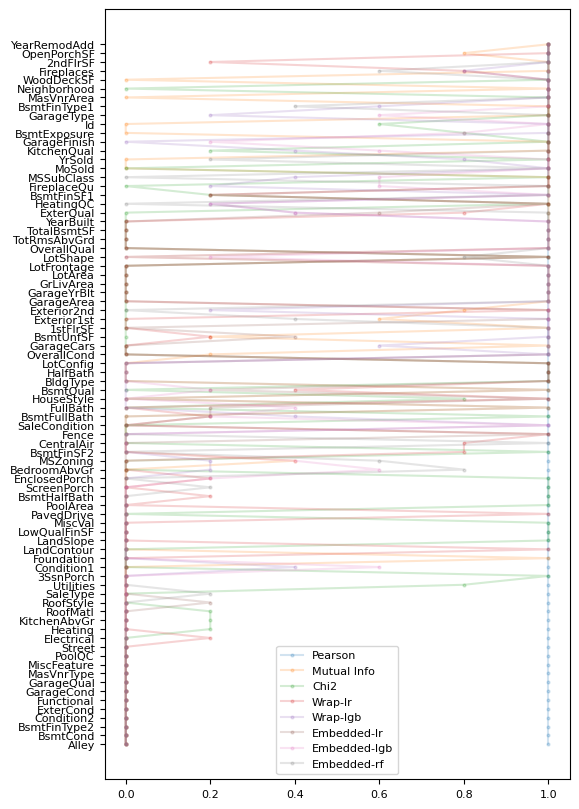

In [189]:
plt.figure(figsize=(6,10))
# col = summary_df.columns.drop(["Feature", "Total"])[5]
for col in summary_df.columns.drop(["Feature", "Total"]):
  plt.plot(summary_df[col], summary_df["Feature"], marker="o", markersize=2, label=col, alpha=0.2)
plt.rcParams["font.size"] = 8
plt.gca().invert_yaxis()
plt.legend()

In [ ]:
hghg

# 過去コード

# 特徴量の選択 参考 ⇒ https://www.kaggle.com/code/sz8416/6-ways-for-feature-selection/notebook

In [ ]:
from sklearn.impute import SimpleImputer
all_data[numerical_list] = SimpleImputer(strategy='median').fit_transform(all_data[numerical_list])

In [ ]:
all_data_le = all_data.copy()
for col in all_data_le.columns[all_data_le.dtypes == object]:
    if col != 'SalePrice':
        le = LabelEncoder()
        all_data_le[col] = le.fit_transform(all_data_le[col])
all_data_le.head()

In [ ]:
train, X_test = all_data_le.iloc[:train.shape[0]], all_data_le.iloc[train.shape[0]:].drop(['SalePrice'], axis=1)
X_train, y_train = train.drop(['SalePrice'], axis=1), train['SalePrice']

### Pearson correlation

In [ ]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [ ]:
feature_name = X_train.columns.tolist()
cor_support, cor_feature = cor_selector(X_train, y_train)
print(str(len(cor_feature)), 'selected features')

## Chi-2



In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X_train)
chi_selector = SelectKBest(chi2, k=20)
chi_selector.fit(X_norm, y_train)

In [ ]:
chi_support = chi_selector.get_support()
chi_feature = X_train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

### Wrapper

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=10, verbose=5)
rfe_selector.fit(X_norm, y_train)

In [ ]:
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

### Embeded

#### LogisticRegression

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="l2")

embeded_lr_selector = SelectFromModel(lr, threshold='1.25*median')
embeded_lr_selector.fit(X_norm, y_train)

In [ ]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

#### RandomForest

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor 

embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X_train, y_train)

In [ ]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

#### lightgbm

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor

model=LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(model, threshold='1.25*median')
embeded_lgb_selector.fit(X_train, y_train)

In [ ]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

### Summary

In [ ]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(100)

### 量的変数

#### Age (Continuous)

In [ ]:
continuous_dist(train, 'Transported', 'Age')
permutation_test(train, 'Transported', 'Age')

#### Age binning

In [ ]:
tmp = train.copy()
tmp['AgeBin'] = 7
for i in range(6):
    tmp.loc[(tmp.Age >= 10*i) & (tmp.Age < 10*(i + 1)), 'AgeBin'] = i
cat_dist(tmp, var='AgeBin', hue='Transported', msg_show=False)

#### その他のContinuous

In [ ]:
# logy引数により対数プロットにしている
for col in continuous_vars:
  all_data[col].plot(kind='hist', logy=True)
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt.show()

In [ ]:
sns.set()
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', "CryoSleep"]
sns.pairplot(train[cols], hue="CryoSleep", size = 2.5,dropna=True)
plt.show();

### カテゴリ変数

#### HomePlanet (Nominal)

In [ ]:
# unique が多すぎる変数に対して実行すると busy になってしまうので注意
cat_dist(train, var='HomePlanet', hue='Transported')
display(train.pivot_table(index="HomePlanet", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
anova_perm(train, "HomePlanet", "Transported", logx=False) # 群が3つ以上なので、ANOVAを利用する

#### Destination (Nominal)

In [ ]:
# unique が多すぎる変数に対して実行すると busy になってしまうので注意
cat_dist(train, var='Destination', hue='Transported')
display(train.pivot_table(index="Destination", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
anova_perm(train, "Destination", "Transported", logx=False) # 群が3つ以上なので、ANOVAを利用する

#### Cabin

In [ ]:
tmp = train.copy()
tmp['Deck'] = train.Cabin.apply(lambda x:str(x)[:1])
tmp['side'] = train.Cabin.apply(lambda x:str(x)[-1:])

#### Deck (Nominal)

In [ ]:
cat_dist(tmp, var='Deck', hue='Transported')
display(tmp.pivot_table(index="Deck", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
anova_perm(tmp, "Deck", "Transported", logx=False) # 群が3つ以上なので、ANOVAを利用する

#### Side (Nominal, Binary)

In [ ]:
cat_dist(tmp, var='side', hue='Transported')
display(tmp.pivot_table(index="side", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
permutation_test(tmp, 'side', "Transported")

#### CryoSleep (Nominal, binary)

In [ ]:
cat_dist(train, var='CryoSleep', hue='Transported')
display(train.pivot_table(index="CryoSleep", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
permutation_test(train, 'CryoSleep', "Transported")

#### VIP (Nominal, Binary)

In [ ]:
cat_dist(train, var='VIP', hue='Transported')
display(train.pivot_table(index="VIP", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
permutation_test(train, 'VIP', "Transported")

### Multinomial Explore

#### HomePlanet and CryoSleep

In [ ]:
# Heatmap can visualize continuous values (or binary variables) in categories and categories.
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='HomePlanet', columns='CryoSleep', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by HomePlanet and CryoSleep', weight='bold', size=15)
g.set_xlabel('CryoSleep', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()

pd.crosstab([train.CryoSleep, train.Transported], train.HomePlanet,margins=True).style.background_gradient()

#### HomePlanet and Destination

In [ ]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='HomePlanet', columns='Destination', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by HomePlanet and Destination', weight='bold', size=15)
g.set_xlabel('Destination', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()

pd.crosstab([train.Destination, train.Transported], train.HomePlanet,margins=True).style.background_gradient()

#### CryoSleep and Destination

In [ ]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='CryoSleep', columns='Destination', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by CryoSleep and Destination', weight='bold', size=15)
g.set_xlabel('Destination', weight='bold', size=13)
g.set_ylabel('CryoSleep', weight='bold', size=13)
plt.show()

pd.crosstab([train.CryoSleep, train.Transported], train.Destination,margins=True).style.background_gradient()

# 分析の方針決め

### 分析前の仮説
- 分析の軸をブレストする
- 方針を決める
- 担当者を決める
- 「確認すること（担当者）」のフォーマットでこのセルにメモをする

# 分析
- 統計検定のコードは、「static_analysys.ipynb」を参照
- 特殊なグラフ化のコードは「visualization_templete.ipynb」を参照

## 確認すること1（担当者）：結果

## 確認すること2（担当者）：結果

### 欠損値への対処
- 消費したお金
  - 仮死状態にあれば、お金は消費していないのでは？
  - 仮死状態にない場合には、属性に応じたそれっぽい値を入れる

In [ ]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

#### TotalSpend

##### CryoSleep＝Trueの場合

In [ ]:
# 仮死状態を選択している場合には、消費金額はゼロ
all_data[all_data['CryoSleep']==True]['TotalSpend'].describe()

In [ ]:
for col in spending_cols:
  all_data.loc[(all_data['CryoSleep']==True) & (all_data[col].isna()), col] = 0
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

##### CryoSleep＝Falseの場合

In [ ]:
# 割とばらつきがある
all_data[all_data['CryoSleep']==False]['TotalSpend'].describe()

In [ ]:
plt.scatter(all_data[all_data['CryoSleep']==False]['Age'], all_data[all_data['CryoSleep']==False]['TotalSpend'])

In [ ]:
# 12歳以下の場合にはTotalSpendは0
for age in np.sort(all_data['Age'].unique()):
  data = all_data[all_data['Age']==age]['TotalSpend']
  print(f"age: {age}, min: {data.min()}, mean: {data.mean()}, max: {data.max()}")

In [ ]:
for col in spending_cols:
  all_data.loc[(all_data['CryoSleep']<13) & (all_data[col].isna()), col] = 0

In [ ]:
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

In [ ]:
all_data.isna().sum()

In [ ]:
all_data.loc[:,['Room']] = all_data.PassengerId.apply(lambda x: x[0:4] )
#Here I want to create handbooks to fill in informations in Cabin, VIP status, HomePlanet and Destination.
guide_VIP=all_data.loc[:,['Room','VIP']].dropna().drop_duplicates('Room')
guide_Cabin=all_data.loc[:,['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet=all_data.loc[:,['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination=all_data.loc[:,['Room','Destination']].dropna().drop_duplicates('Room')
all_data=pd.merge(all_data,guide_Cabin,how="left",on='Room',suffixes=('','_y'))
all_data=pd.merge(all_data,guide_VIP,how="left",on='Room',suffixes=('','_y'))
all_data=pd.merge(all_data,guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
all_data=pd.merge(all_data,guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [ ]:
all_data.loc[:,['VIP']]=all_data.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
all_data.loc[:,['Cabin']]=all_data.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
all_data.loc[:,['HomePlanet']]=all_data.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
all_data.loc[:,['Destination']]=all_data.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

In [ ]:
all_data["FirstName"] = all_data['Name'].str.split(" ",expand=True)[0]
all_data["LastName"] = all_data['Name'].str.split(" ",expand=True)[1]

In [ ]:
all_data["Room_LastName"] = all_data['Room']+"_"+all_data["LastName"]

In [ ]:
guide_CryoSleep=all_data.loc[:,['Room','CryoSleep']].dropna().drop_duplicates('Room')
all_data=pd.merge(all_data,guide_CryoSleep,how="left",on='Room',suffixes=('','_y'))
all_data.loc[:,['CryoSleep']]=all_data.apply(lambda x: x.CryoSleep_y if pd.isna(x.CryoSleep) else x,axis=1)

In [ ]:
all_data.isna().sum()

In [ ]:
all_data.columns

### CryoSleepの欠損値を埋めたい

#### XGboost により欠損値を埋める

In [ ]:
all_data['Deck'] = all_data.Cabin.apply(lambda x:str(x)[:1])
all_data['Side'] = all_data.Cabin.apply(lambda x:str(x)[-1:])

In [ ]:
tmp_all_data = all_data[~(all_data["CryoSleep"].isna())]

In [ ]:
# convert to continuous value
for col in tmp_all_data.columns[tmp_all_data.dtypes == object]:
    if col != 'CryoSleep':
        le = LabelEncoder()
        tmp_all_data[col] = le.fit_transform(tmp_all_data[col])
tmp_all_data['VIP'] = tmp_all_data['VIP'].astype('int')

In [ ]:
feature_fill_CryoSleep = ['HomePlanet', 'Cabin', "Deck", "Side", 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'TotalSpend', 'Room']
target_fill_CryoSleep = 'CryoSleep'
X = pd.DataFrame(tmp_all_data, columns=feature_fill_CryoSleep)
y = pd.Series(tmp_all_data[target_fill_CryoSleep])

In [ ]:
X.head()

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

In [ ]:
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred = bst.predict(X_test)

In [ ]:
pd.Series(y_pred).value_counts()

In [ ]:
cm = confusion_matrix(list(y_test), list(y_pred))

print(cm)

In [ ]:
print(f1_score(list(y_test), list(y_pred)))

In [ ]:
all_data[all_data["CryoSleep"].isna()]["CryoSleep"]

In [ ]:
# convert to continuous value
for col in all_data.columns[all_data.dtypes == object]:
    if col != 'CryoSleep':
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col])
all_data['VIP'] = all_data['VIP'].astype('int')

In [ ]:
X_fill_CryoSleep = pd.DataFrame(all_data[all_data["CryoSleep"].isna()], columns=feature_fill_CryoSleep)

In [ ]:
y_fill_CryoSleep = bst.predict(X_fill_CryoSleep)

In [ ]:
y_fill_CryoSleep_index = pd.Series(y_fill_CryoSleep, index=all_data[all_data["CryoSleep"].isna()].index)

In [ ]:
all_data.loc[all_data["CryoSleep"].isna(), "CryoSleep"] = y_fill_CryoSleep_index

#### 欠損値を埋めたので、お金関連の欠損値を埋め直す

In [ ]:
for col in spending_cols:
  all_data.loc[(all_data['CryoSleep']==True) & (all_data[col].isna()), col] = 0
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

#### TotalSpendが、4か所欠損値となっているので、適当な値で埋める

In [ ]:
all_data[all_data["TotalSpend"].isna()]

In [ ]:
# 各値について、中央値は０
for age in all_data[all_data["TotalSpend"].isna()]["Age"]:
    for col in spending_cols:
        median = all_data[all_data["Age"]==age][col].median()
        print(f"age: {age}, col: {col}, median: {median}")

In [ ]:
for col in spending_cols:
  all_data.loc[all_data[col].isna(), col] = 0.0

In [ ]:
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

In [ ]:
all_data.isna().sum()

### Ageの欠損値を埋めたい

#### XGboost により欠損値を埋める

In [ ]:
all_data['CryoSleep'] = all_data['CryoSleep'].astype('int')

In [ ]:
tmp_all_data = all_data[~(all_data["Age"].isna())]

In [ ]:
feature_fill_Age = ['HomePlanet', 'Cabin', "Deck", "Side", 'Destination', 'CryoSleep',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'TotalSpend', 'Room']
target_fill_Age = 'Age'
X = pd.DataFrame(tmp_all_data, columns=feature_fill_Age)
y = pd.Series(tmp_all_data[target_fill_Age])

In [ ]:
X.head()

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

In [ ]:
# fit model
xgb_r.fit(X_train, y_train)
# make predictions
y_pred = xgb_r.predict(X_test)

In [ ]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_pred))

In [ ]:
print(rmse)

In [ ]:
all_data[all_data["Age"].isna()]["Age"]

In [ ]:
X_fill_Age = pd.DataFrame(all_data[all_data["Age"].isna()], columns=feature_fill_Age)

In [ ]:
y_fill_Age = xgb_r.predict(X_fill_Age)

In [ ]:
y_fill_Age_index = pd.Series(y_fill_Age, index=all_data[all_data["Age"].isna()].index)

In [ ]:
all_data.loc[all_data["Age"].isna(), "Age"] = y_fill_Age_index

## 学習してみる

In [ ]:
all_data['PctRoomService'] = all_data['RoomService']/all_data['TotalSpend']
all_data['PctFoodCourt'] = all_data['FoodCourt']/all_data['TotalSpend']
all_data['PctShoppingMall'] = all_data['ShoppingMall']/all_data['TotalSpend']
all_data['PctSpa'] = all_data['Spa']/all_data['TotalSpend']
all_data['PctVRDeck'] = all_data['VRDeck']/all_data['TotalSpend']
all_data

In [ ]:
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
all_data[fill_cols] = all_data[fill_cols].fillna(0)

In [ ]:
all_data.columns

In [ ]:
feature_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Age',
       'VIP', 'Transported', 'TotalSpend', 'Room', 'Deck', 'Side', 'PctRoomService',
       'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']

In [ ]:
df_ml = all_data[feature_cols]

In [ ]:
df_ml

In [ ]:
train, X_test = all_data.iloc[:train.shape[0]], all_data.iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
display(train.shape)
display(X_test.shape)
display(X_train.shape)
display(y_train.shape)

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

In [ ]:
scores = []

kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(X_train):
  tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
  tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

  model.fit(tr_x, tr_y)
  va_pred = model.predict(va_x)
  score = accuracy_score(va_y, va_pred)
  scores.append(score)
print(np.mean(scores))